<a href="https://colab.research.google.com/github/Mandlez/Finance/blob/main/Portfolio_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
from tabulate import tabulate
from datetime import datetime

In [ ]:
tickers = ["VLTSA.PA", "OR.PA", "SQI.PA", "ALEMG.PA", "FDE.PA", "SU.PA", "FII.PA", "MC.PA",
    "AIR.PA", "SAF.PA", "GE", "NEOEN.PA", "VIV.PA", "RBT.PA", "AI.PA", "GTT.PA", "RMS.PA", "ESI.PA", "AZN", "TSLA"]

In [ ]:
start_date = "2019-01-01"
end_date = "2023-01-01"

# Télécharger les données
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Remplir les valeurs manquantes en propageant la dernière valeur observée
data_filled = data.fillna(method='ffill')

# Afficher les données remplies
data_filled

[*********************100%%**********************]  20 of 20 completed


AI.PA      AIR.PA  ALEMG.PA        AZN     ESI.PA     FDE.PA  \
Date                                                                            
2019-01-02   79.245094   78.120621      6.60  33.105095  27.150000  11.300000   
2019-01-03   77.788658   75.373360      6.60  33.569267  27.450001  11.350000   
2019-01-04   79.954628   79.002342      6.60  34.313694  27.850000  11.800000   
2019-01-07   79.506493   77.554459      6.60  33.963367  27.000000  11.800000   
2019-01-08   79.618538   80.422379      6.60  33.394104  28.200001  13.000000   
...                ...         ...       ...        ...        ...        ...   
2022-12-23  131.290619  110.171593      4.54  66.570320  72.800003  38.049999   
2022-12-27  131.506653  111.236435      4.45  66.521355  73.599998  38.099998   
2022-12-28  130.956757  110.053284      4.34  66.159027  73.800003  37.549999   
2022-12-29  132.272598  110.447662      4.51  66.687828  73.800003  39.150002   
2022-12-30  130.014053  109.461700      4.81  66.394051  73.800003  39.400002   

               FII.PA         GE     GTT.PA       MC.PA   NEOEN.PA  \
Date                                                                 
2019-01-02  21.223192  47.404755  54.151310  232.625519  18.914120   
2019-01-03  20.983112  47.463631  54.928986  223.763168  18.794912   
2019-01-04  21.559307  48.464718  55.706669  230.651016  18.715441   
2019-01-07  21.751371  51.468010  55.870396  230.237747  18.933987   
2019-01-08  23.768053  50.408024  55.624805  237.447006  19.371078   
...               ...        ...        ...         ...        ...   
2022-12-23  19.085487  63.656471  98.465782  663.311829  38.137272   
2022-12-27  19.184891  64.473679  98.271950  679.456604  38.017780   
2022-12-28  19.880716  63.796566  97.787376  675.912598  37.639393   
2022-12-29  19.880716  65.181923  98.271950  685.658508  37.838547   
2022-12-30  19.343935  65.213051  96.721313  669.316956  37.450203   

                 OR.PA      RBT.PA       RMS.PA      SAF.PA     SQI.PA  \
Date                                                                     
2019-01-02  183.077667  483.915802   462.388916  100.064110  16.139999   
2019-01-03  180.876312  487.741241   449.222015   97.791023  15.900000   
2019-01-04  183.444534  501.130188   462.582458  101.756836  16.059999   
2019-01-07  181.105637  506.868378   457.160858  100.064110  16.100000   
2019-01-08  182.206299  493.479370   464.615631  102.965919  16.420000   
...                ...         ...          ...         ...        ...   
2022-12-23  328.625824  826.479614  1433.316040  116.419708  43.700001   
2022-12-27  332.077240  826.479614  1462.618042  118.202248  43.700001   
2022-12-28  330.745972  836.377563  1452.685181  116.835640  44.000000   
2022-12-29  334.000214  829.448975  1475.034180  116.875244  44.000000   
2022-12-30  328.970978  828.459167  1435.302734  115.785919  44.000000   

                 SU.PA        TSLA     VIV.PA   VLTSA.PA  
Date                                                      
2019-01-02   52.222748   20.674667  18.910679   7.952106  
2019-01-03   50.776531   20.024000  18.741514   7.933307  
2019-01-04   52.663673   21.179333  19.062035   7.942707  
2019-01-07   52.434387   22.330667  19.266809   7.895708  
2019-01-08   52.840038   22.356667  19.320232   7.764113  
...                ...         ...        ...        ...  
2022-12-23  128.577881  123.150002   8.712449  17.080000  
2022-12-27  129.852097  109.099998   8.663722  16.959999  
2022-12-28  129.205200  112.709999   8.650079  16.940001  
2022-12-29  130.851868  121.820000   8.784566  17.240000  
2022-12-30  128.127014  123.180000   8.687111  17.059999  

[1035 rows x 20 columns]

In [ ]:
# Calcul des rendements quotidiens en ne prenant en compte que les jours où il y a eu des variations
daily_returns = np.log(data_filled / data_filled.shift(1)).dropna()

# Fonction pour colorer les valeurs positives en vert et négatives en rouge
def color_positive_green(val):
    color = 'green' if val > 0 else 'red'
    return f'color: {color}'

# Fonction pour formater les nombres en pourcentage avec 3 décimales
def format_percentage(val):
    return f'{val:.3%}'

# Création d'un DataFrame stylisé à partir des rendements quotidiens
styled_df = daily_returns.style.applymap(color_positive_green).format(format_percentage)

# Afficher le DataFrame stylisé
styled_df

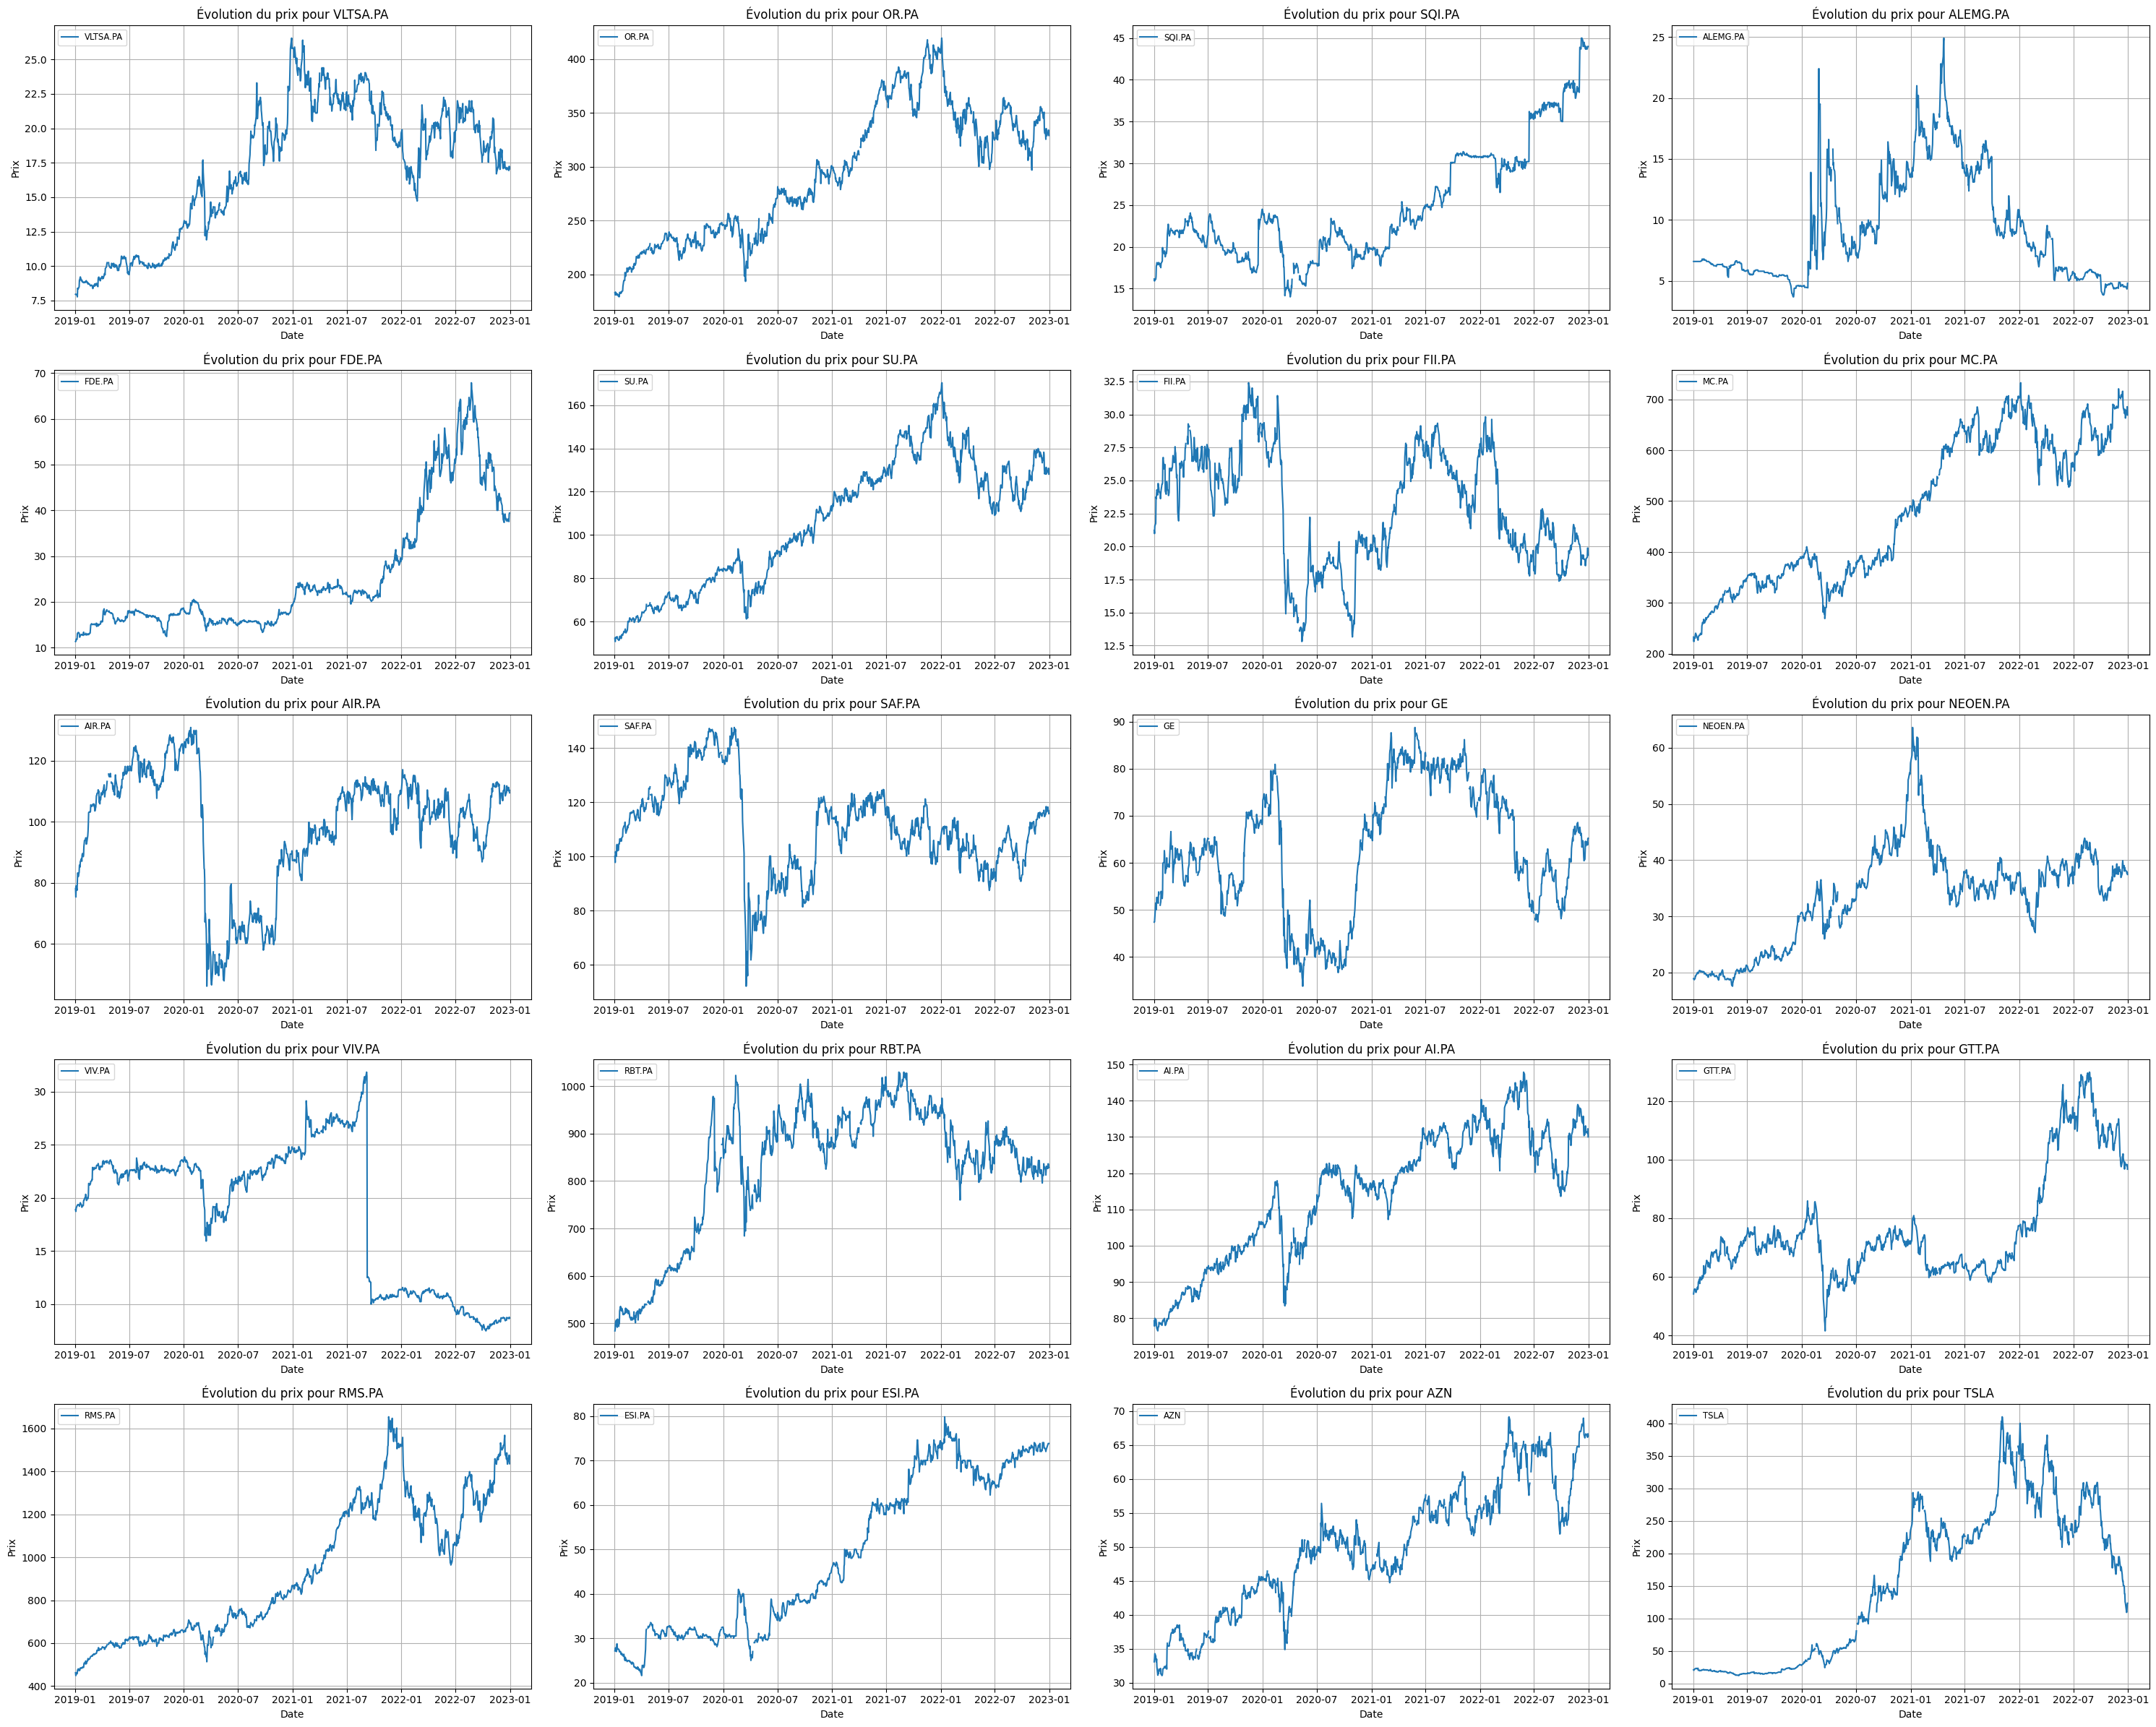

In [ ]:
# Tracer l'évolution du prix pour chaque société dans un seul graphique avec plusieurs sous-graphiques
plt.figure(figsize=(30, 24))  # Ajustez la taille si nécessaire

for i, company in enumerate(tickers, start=1):
    ax = plt.subplot(5, 4, i)
    ax.plot(data.index, data[company], label=company)
    ax.title.set_text(f'Évolution du prix pour {company}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Prix')
    ax.grid(True)
    ax.legend(loc='upper left', fontsize='small')

plt.tight_layout()  # Ajustement automatique des espaces entre les sous-graphiques
plt.show()

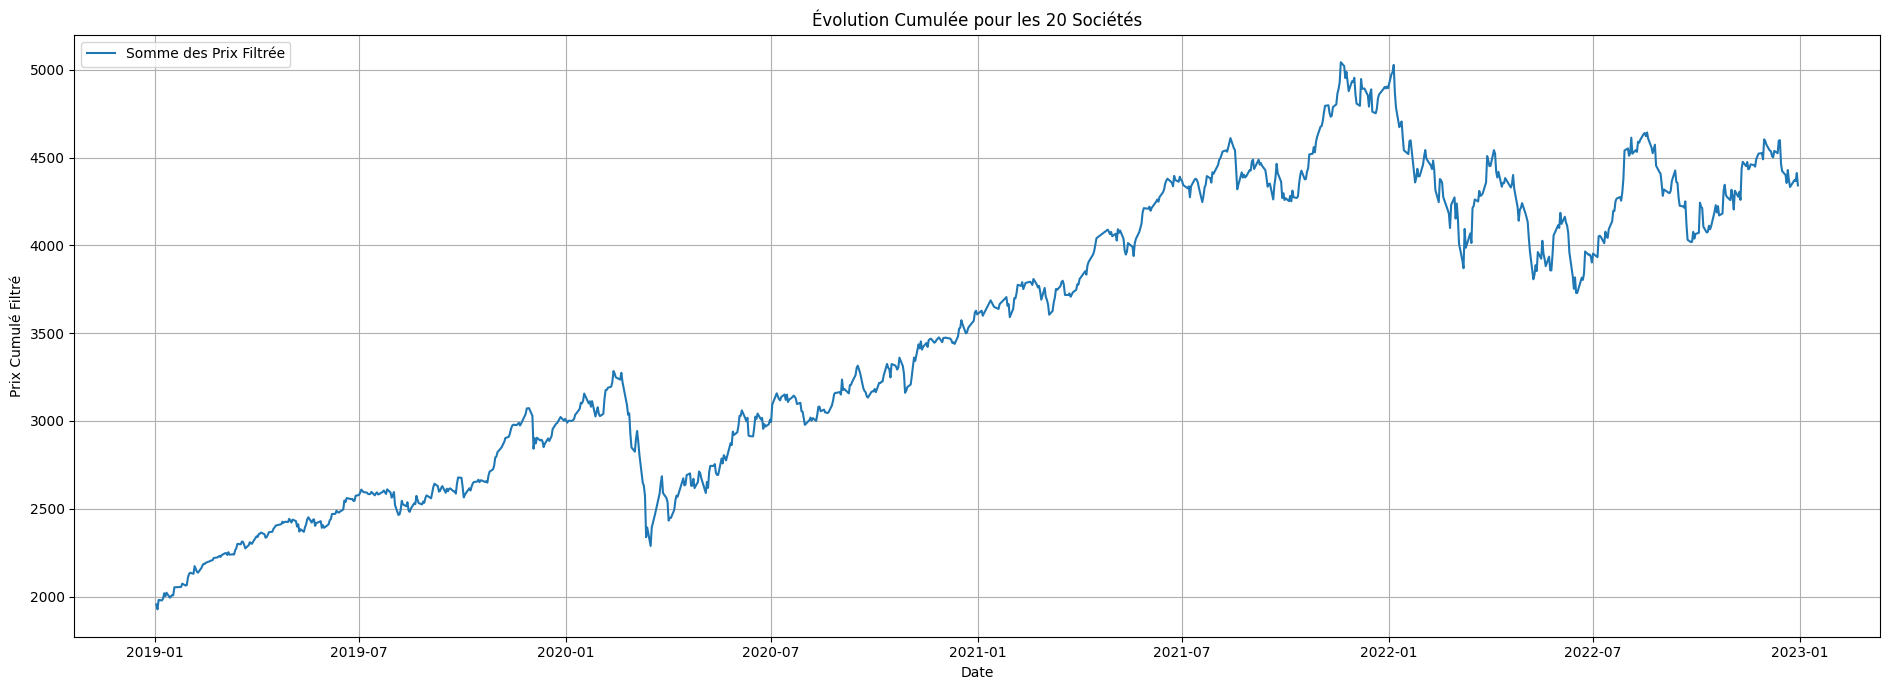

In [ ]:
# Calculer la moyenne et l'écart-type des prix
mean_price = data.mean()
std_price = data.std()

# Filtrer les valeurs qui sont à moins de 3 écarts-types de la moyenne
filtered_data = data[(np.abs(data - mean_price) <= (3 * std_price)).all(axis=1)]

# Somme des prix pour chaque date après le filtrage
sum_prices_filtered = filtered_data.sum(axis=1)

# Tracer le graphique filtré
plt.figure(figsize=(19, 7))
plt.plot(sum_prices_filtered.index, sum_prices_filtered, label='Somme des Prix Filtrée')
plt.title('Évolution Cumulée pour les 20 Sociétés')
plt.xlabel('Date')
plt.ylabel('Prix Cumulé Filtré')
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

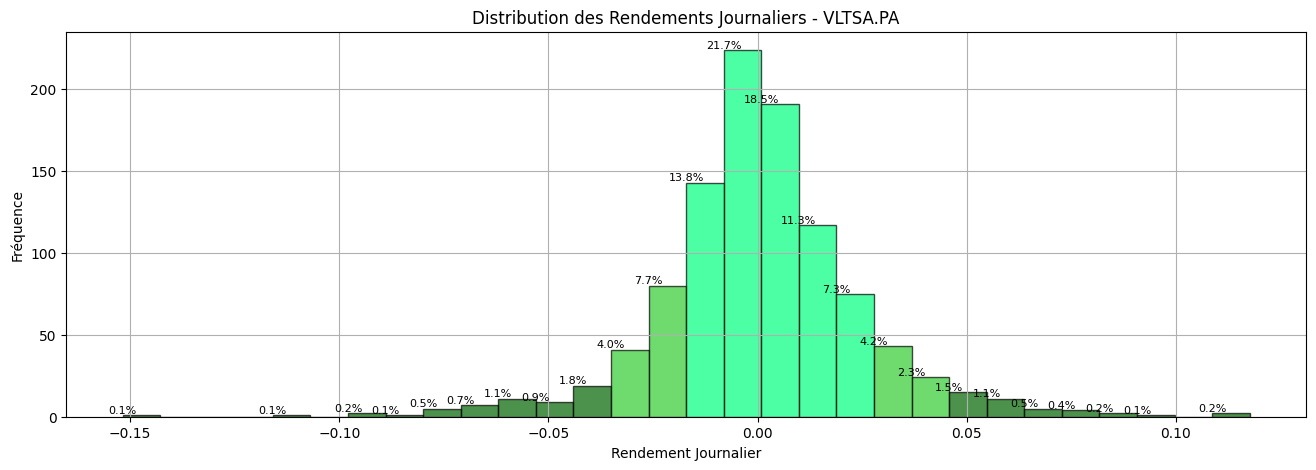

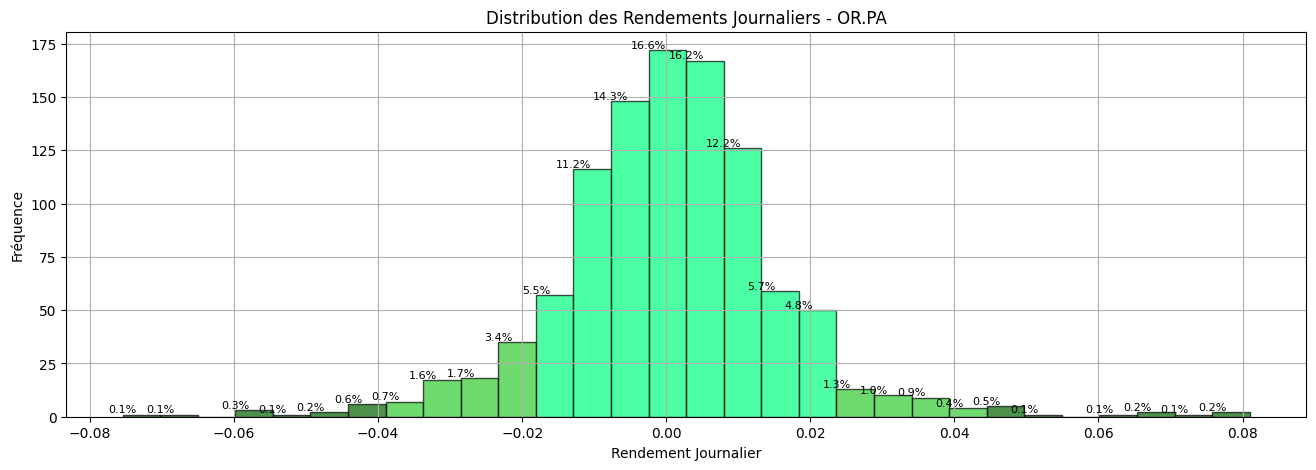

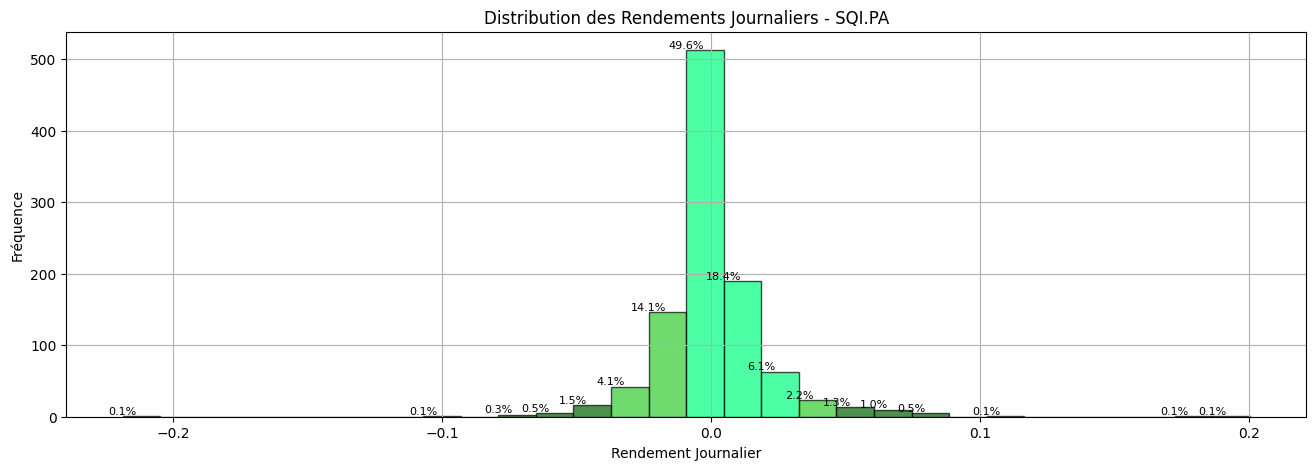

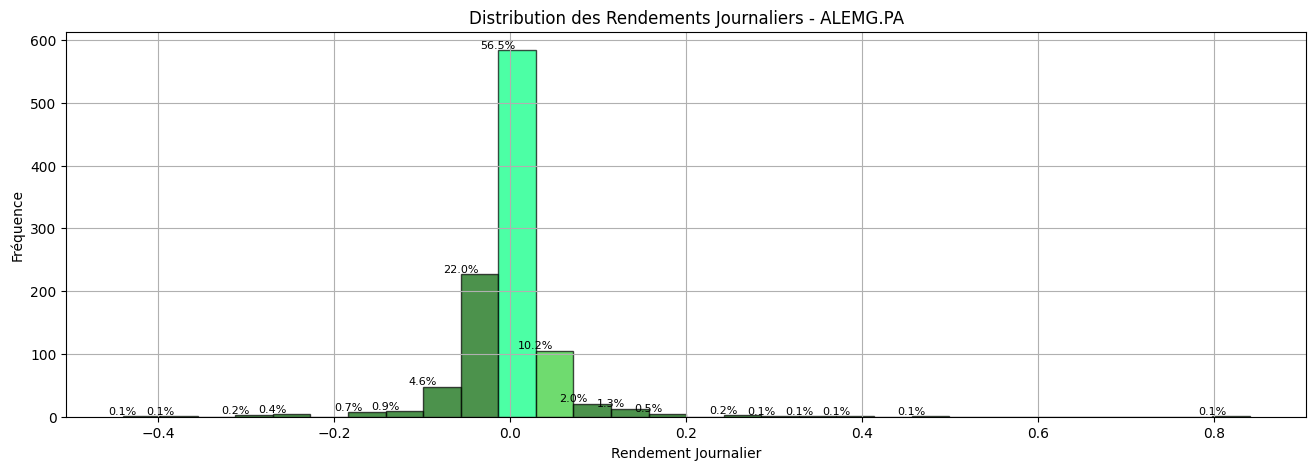

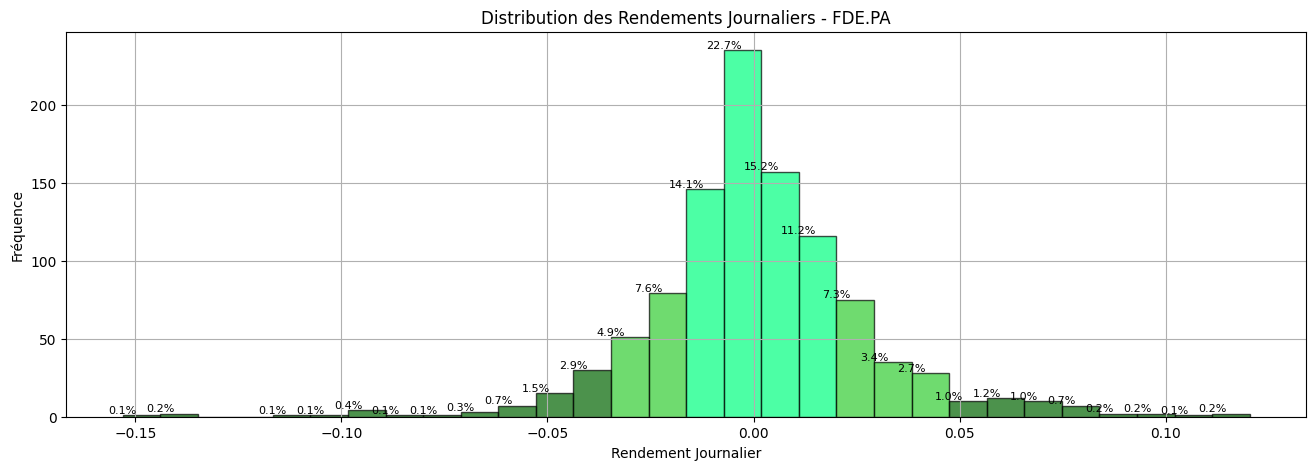

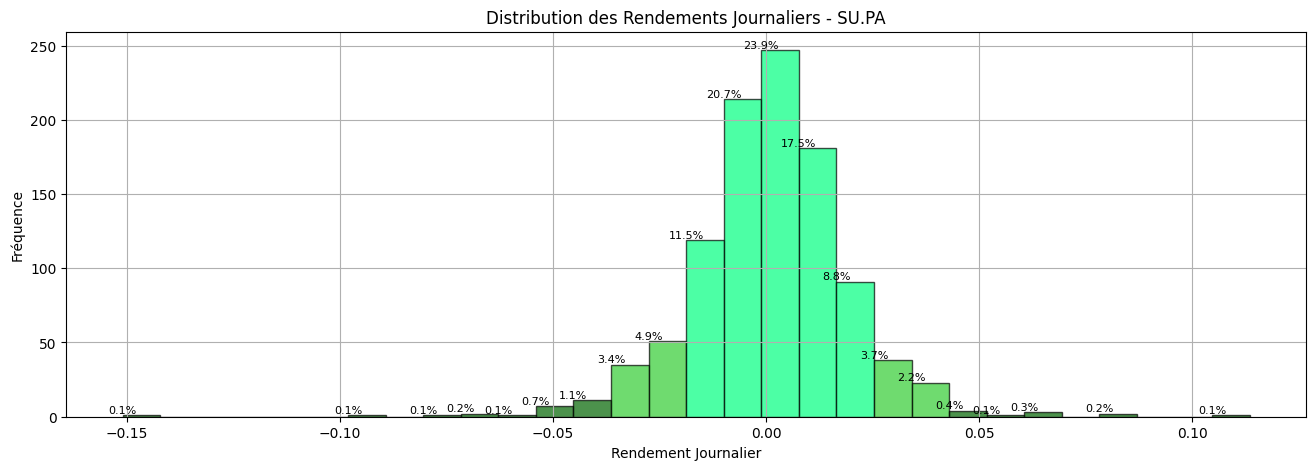

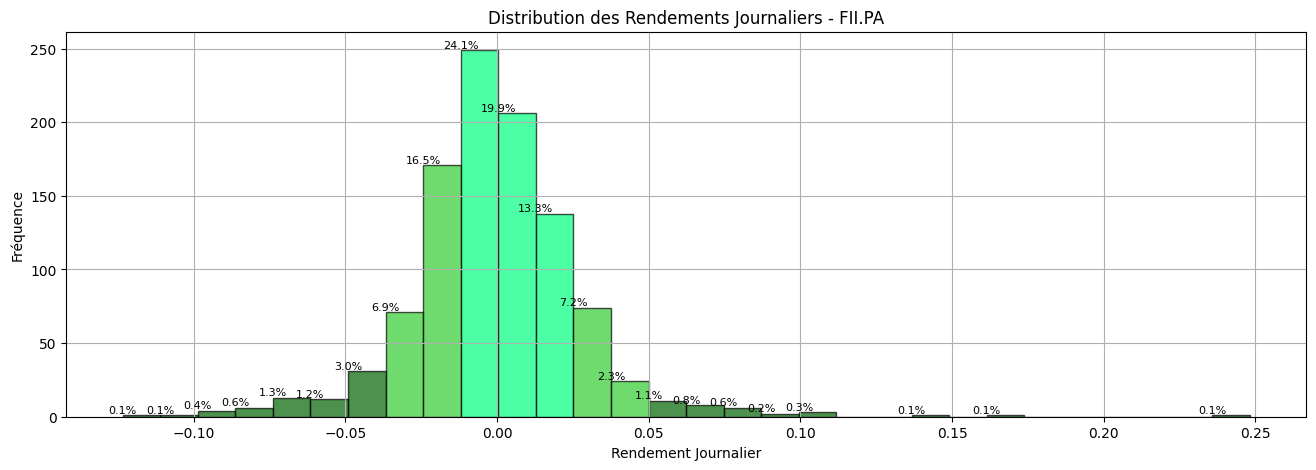

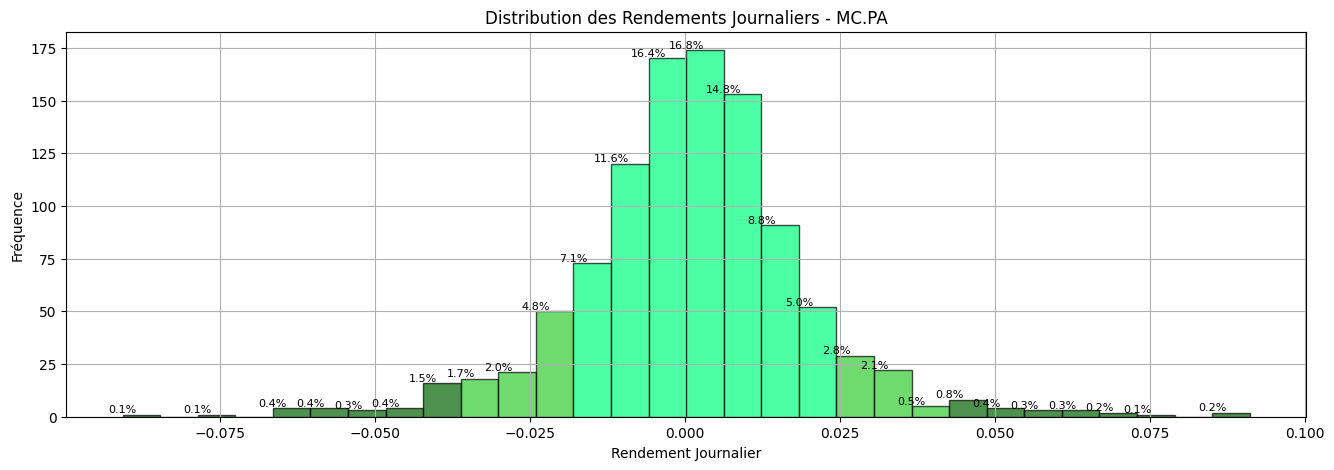

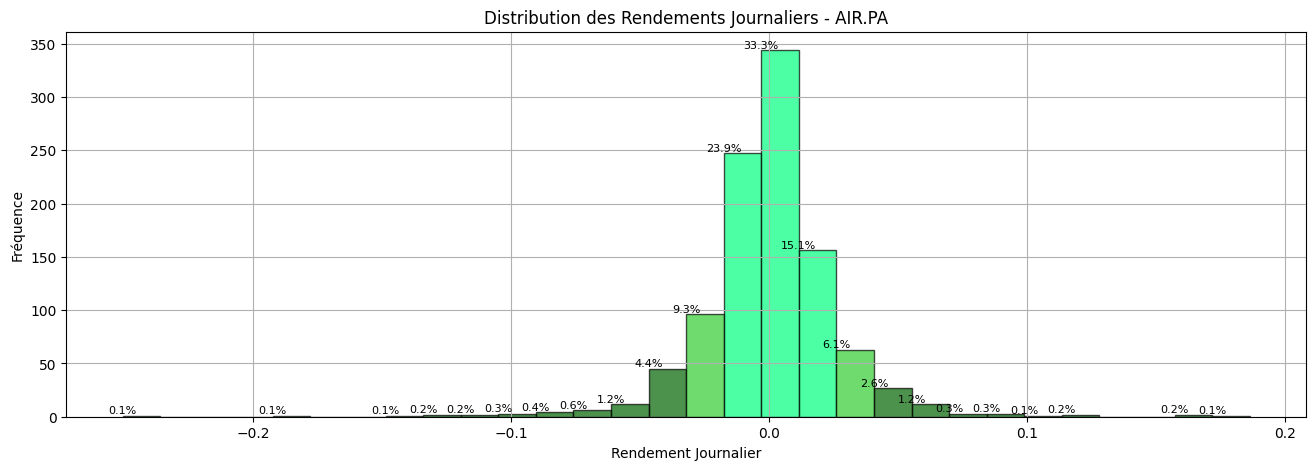

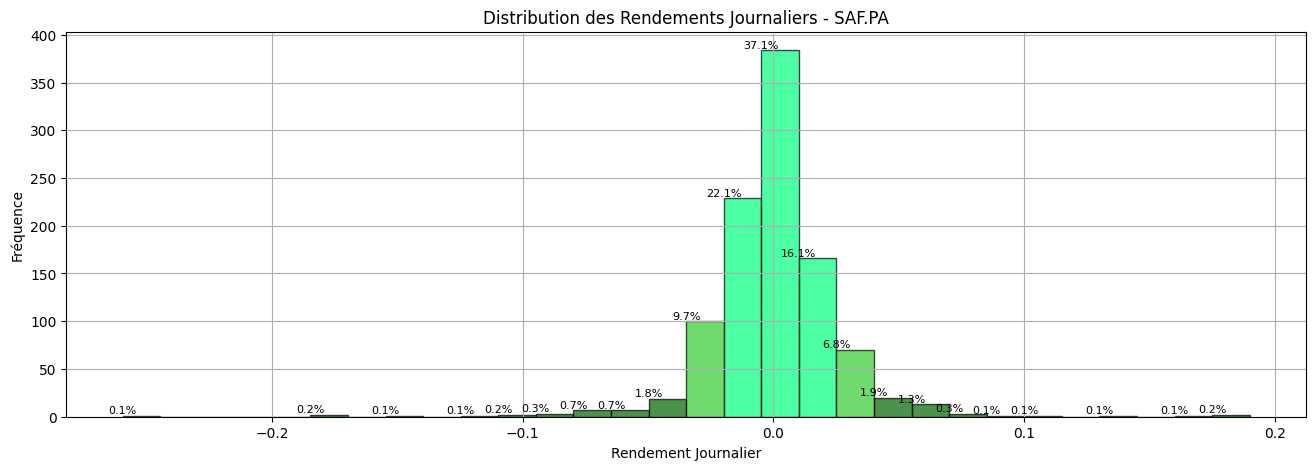

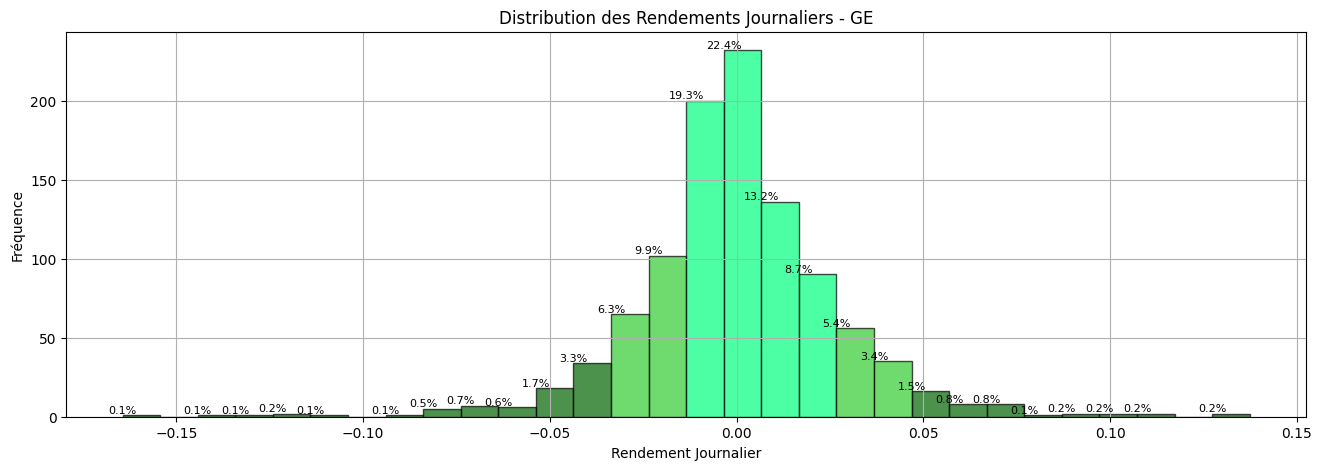

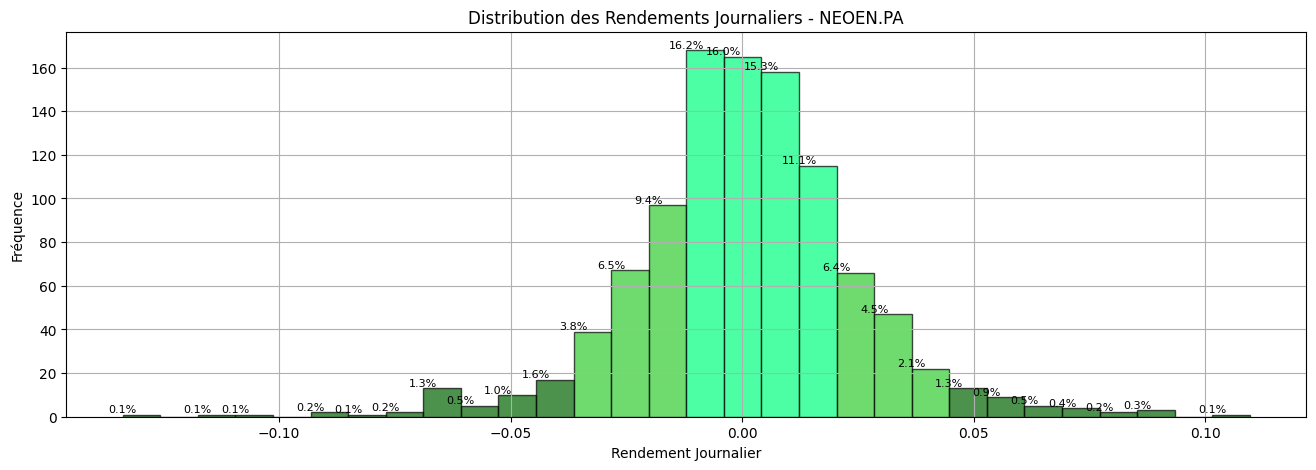

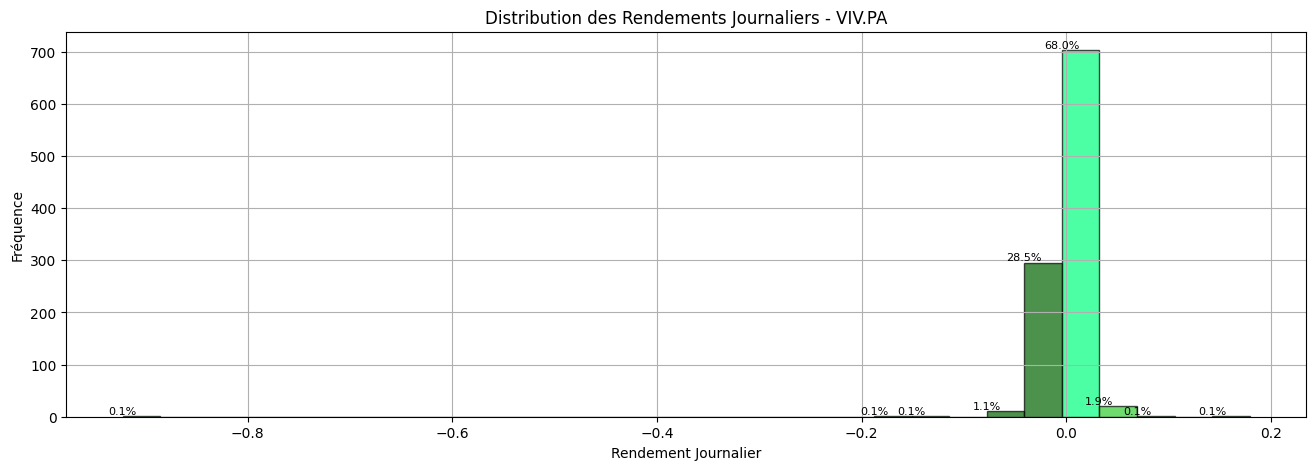

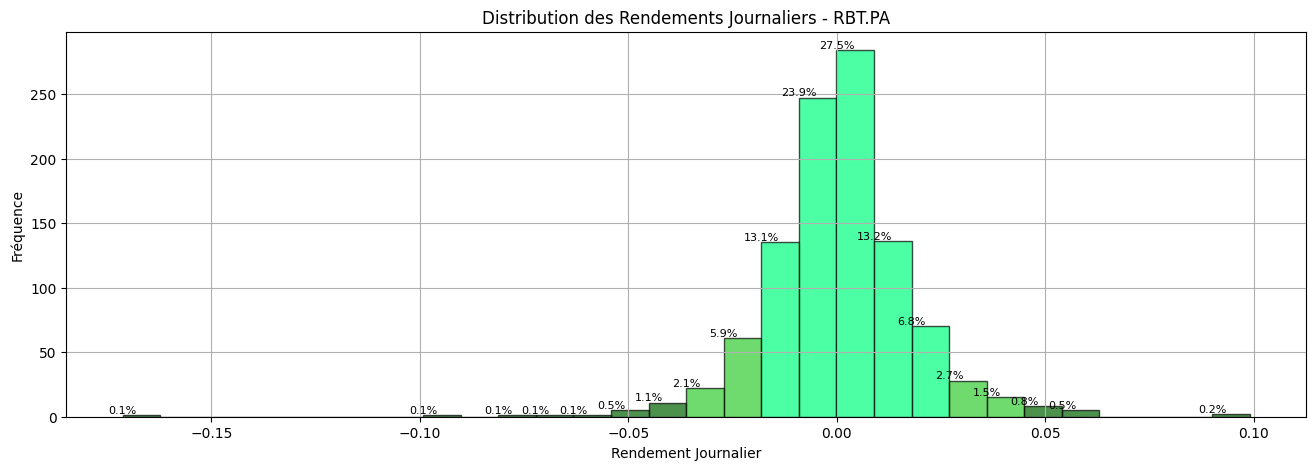

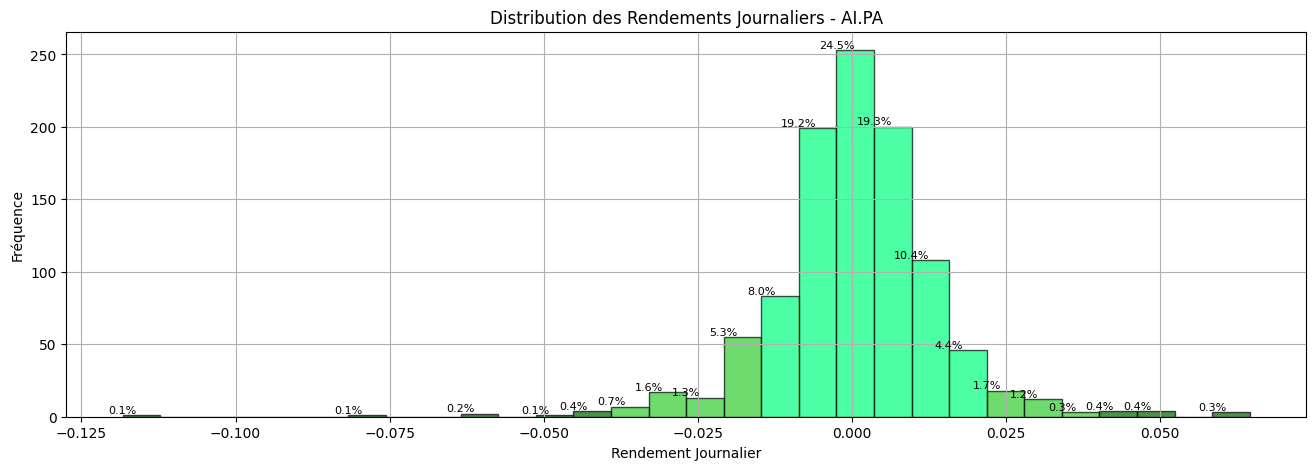

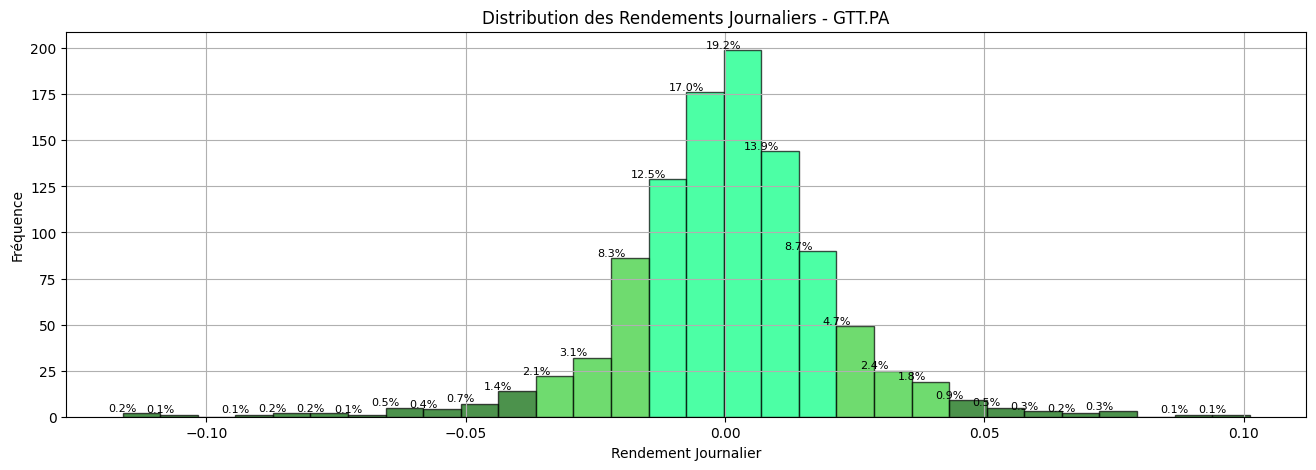

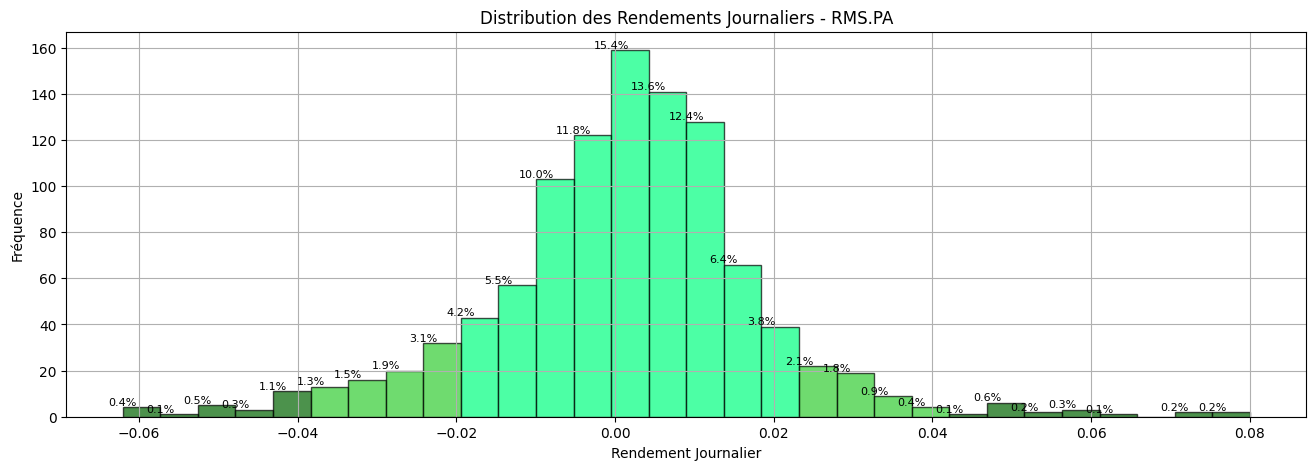

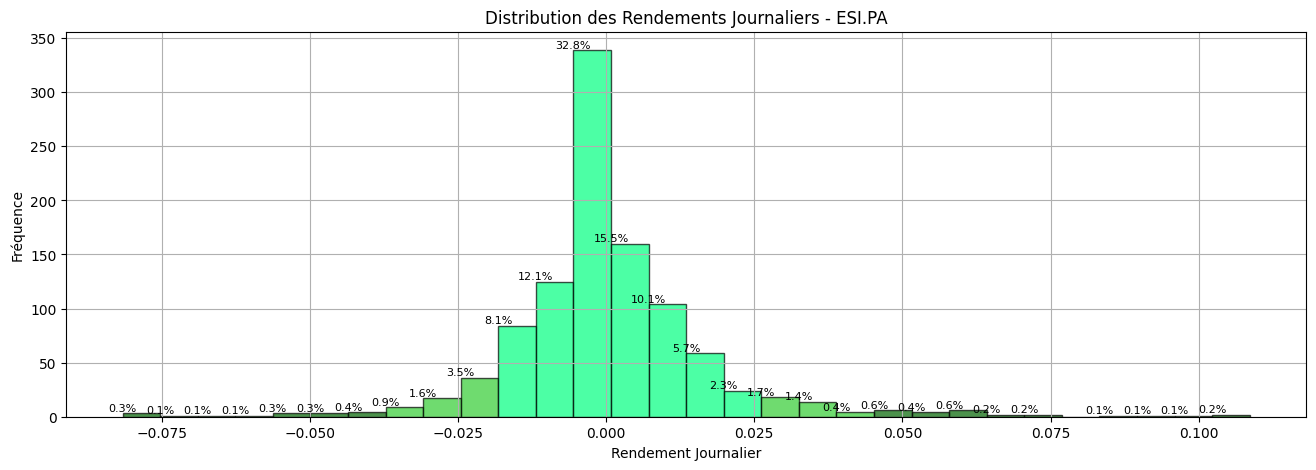

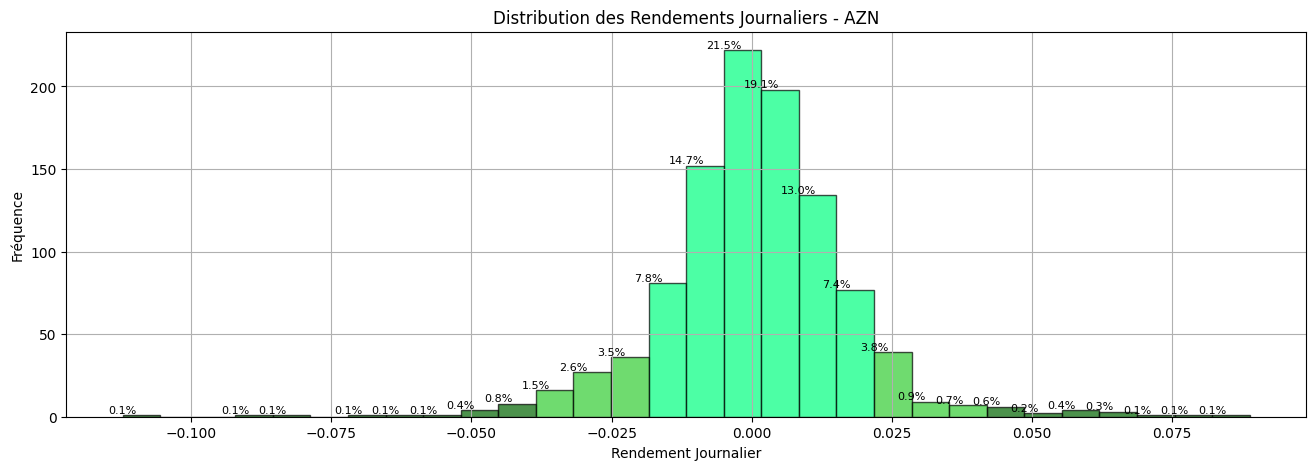

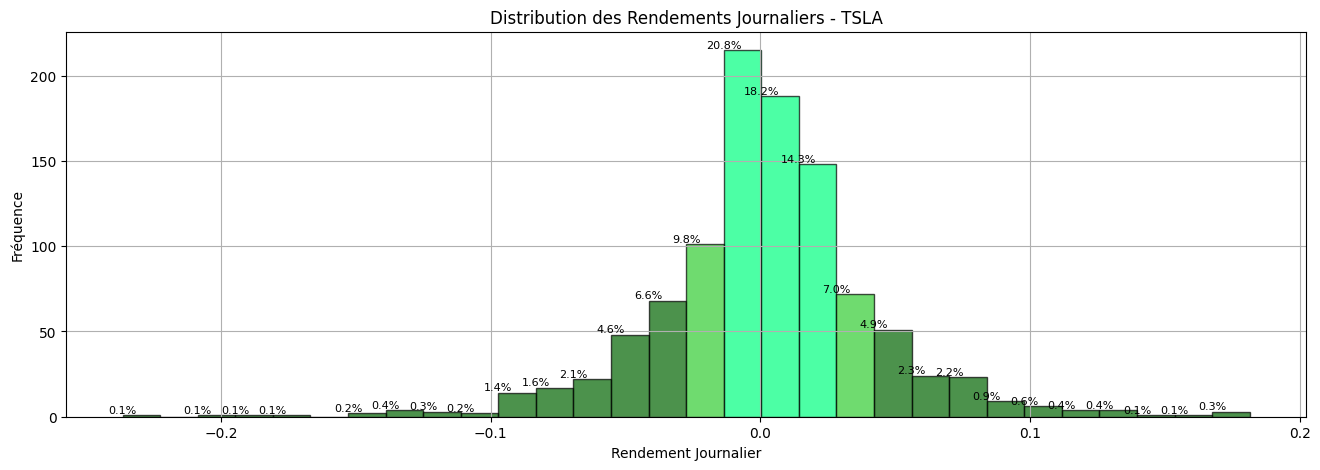

In [ ]:
for ticker in tickers:
    plt.figure(figsize=(16, 5))

    # Tracer l'histogramme des rendements journaliers
    n, bins, patches = plt.hist(daily_returns[ticker].dropna(), bins=30, edgecolor='black', alpha=0.7)

    # Ajouter des pourcentages sur les barres
    for count, value, patch in zip(n, bins, patches):
        if count > 0:
            percentage = count / len(daily_returns[ticker].dropna()) * 100
            plt.text(value, count, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=8)

    # Mettre en vert les barres entre -0.2 et 0.2
    # Mettre en rouge intense les barres supérieures à 0.4
    for patch, value in zip(patches, bins):
        if abs(value) > 0.04:
            patch.set_facecolor('darkgreen')
        elif abs(value) > 0.02:
            patch.set_facecolor('limegreen')
        else:
            patch.set_facecolor('springgreen')

    plt.title(f'Distribution des Rendements Journaliers - {ticker}')
    plt.xlabel('Rendement Journalier')
    plt.ylabel('Fréquence')
    plt.grid(True)
    plt.show()

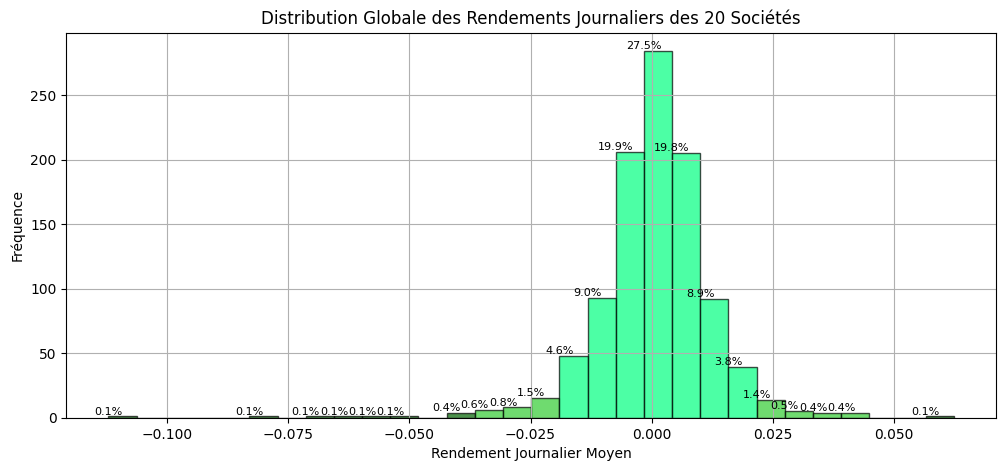

In [ ]:
# Calculer les rendements moyens journaliers pour toutes les sociétés
mean_daily_returns = daily_returns.mean(axis=1)

plt.figure(figsize=(12, 5))

# Tracer l'histogramme des rendements moyens journaliers
n, bins, patches = plt.hist(mean_daily_returns.dropna(), bins=30, edgecolor='black', alpha=0.7)

# Ajouter des pourcentages sur les barres
for count, value, patch in zip(n, bins, patches):
    if count > 0:
        percentage = count / len(mean_daily_returns.dropna()) * 100
        plt.text(value, count, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=8)

# Mettre en couleur les barres selon les mêmes critères
for patch, value in zip(patches, bins):
    if abs(value) > 0.04:
        patch.set_facecolor('darkgreen')
    elif abs(value) > 0.02:
        patch.set_facecolor('limegreen')
    else:
        patch.set_facecolor('springgreen')

plt.title('Distribution Globale des Rendements Journaliers des 20 Sociétés')
plt.xlabel('Rendement Journalier Moyen')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()


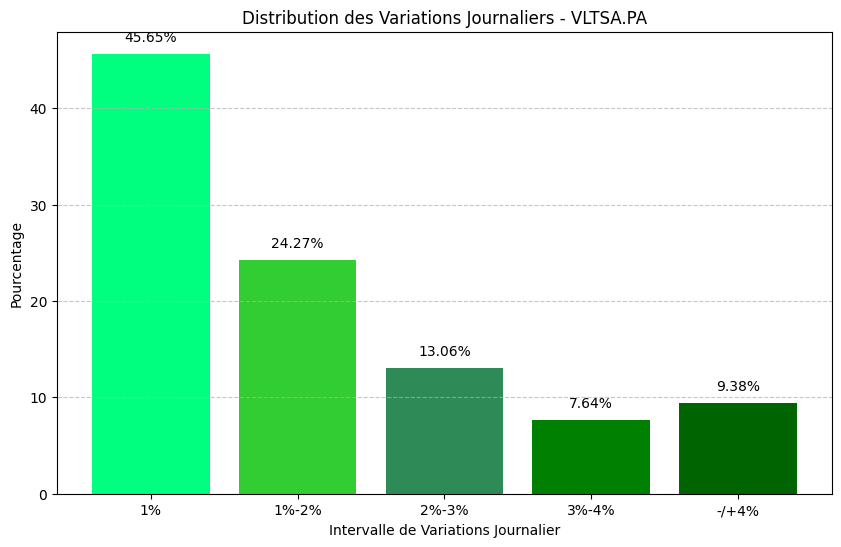

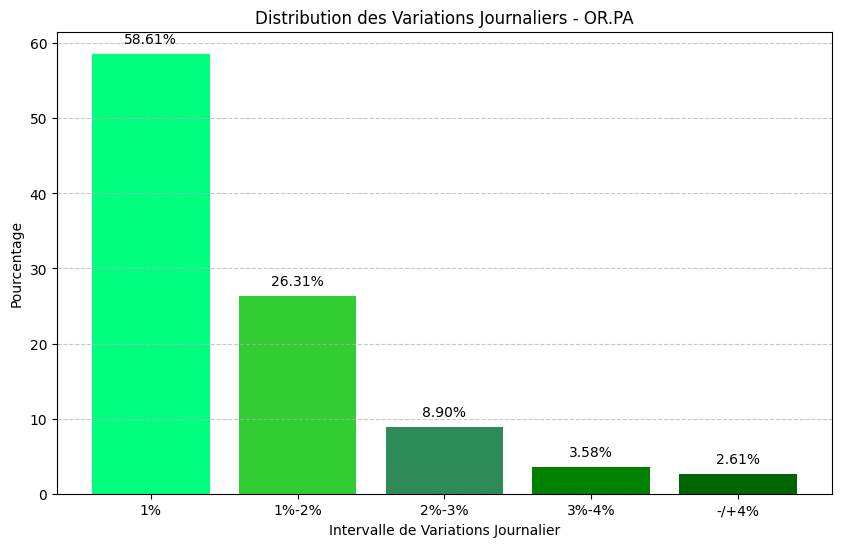

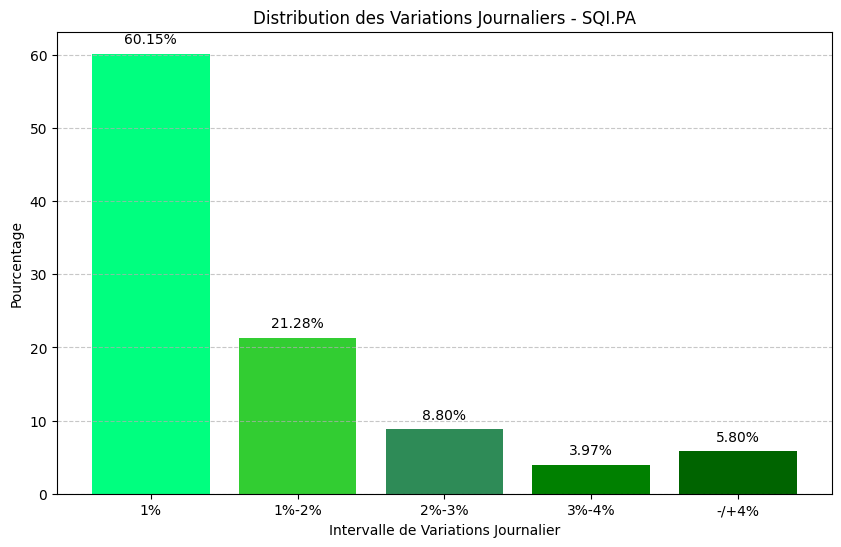

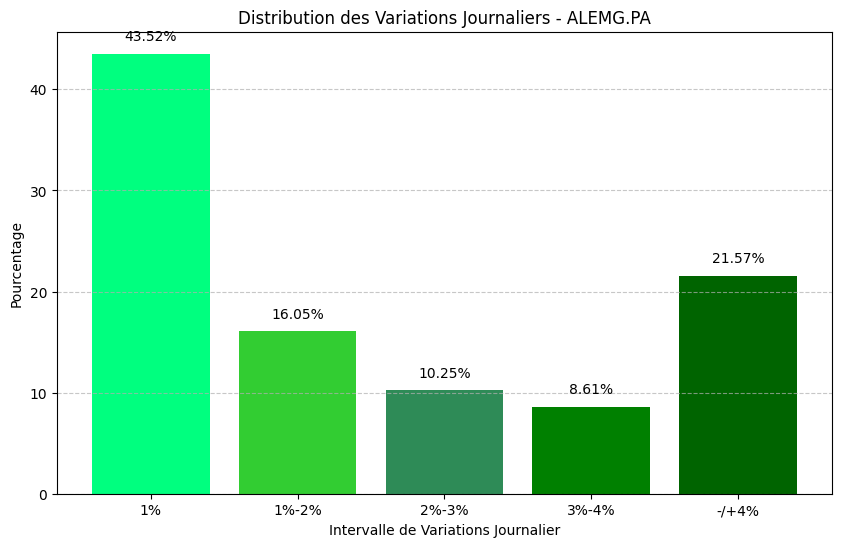

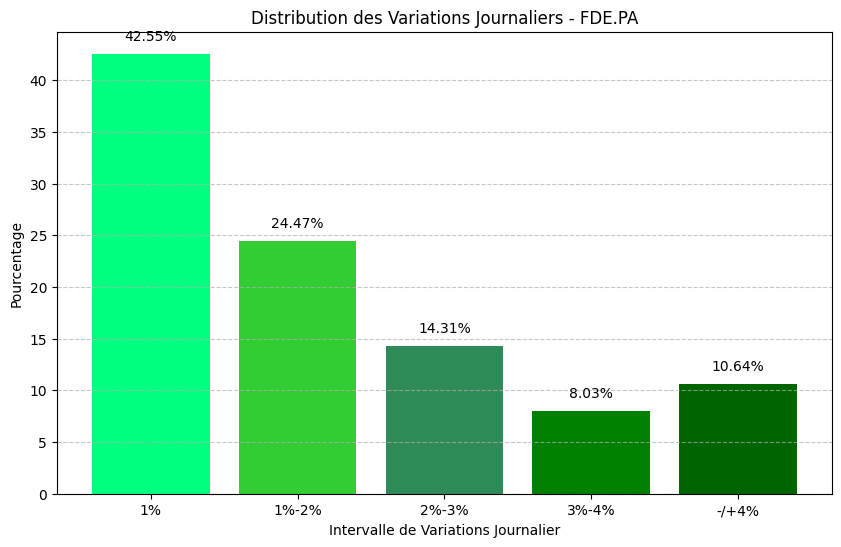

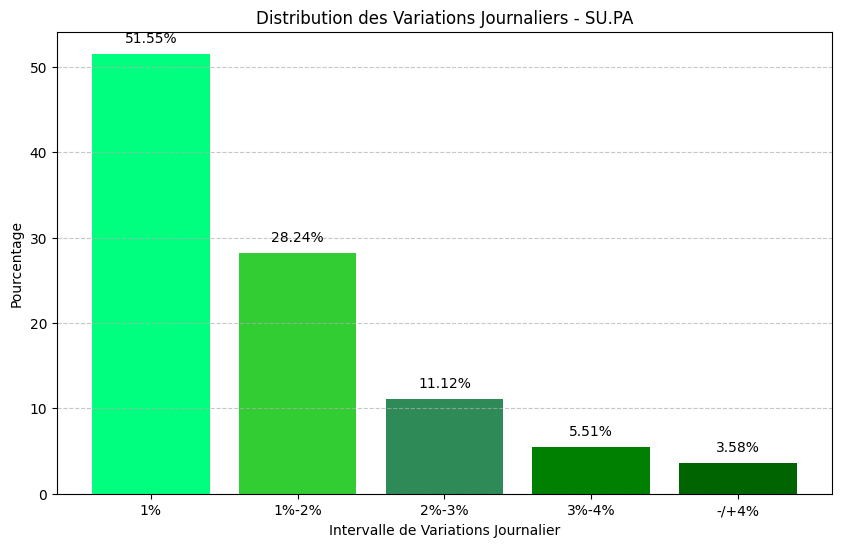

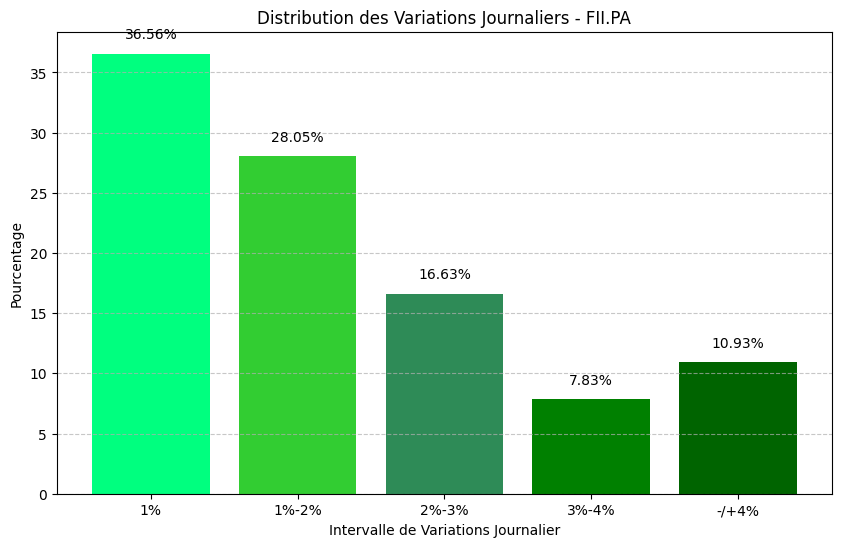

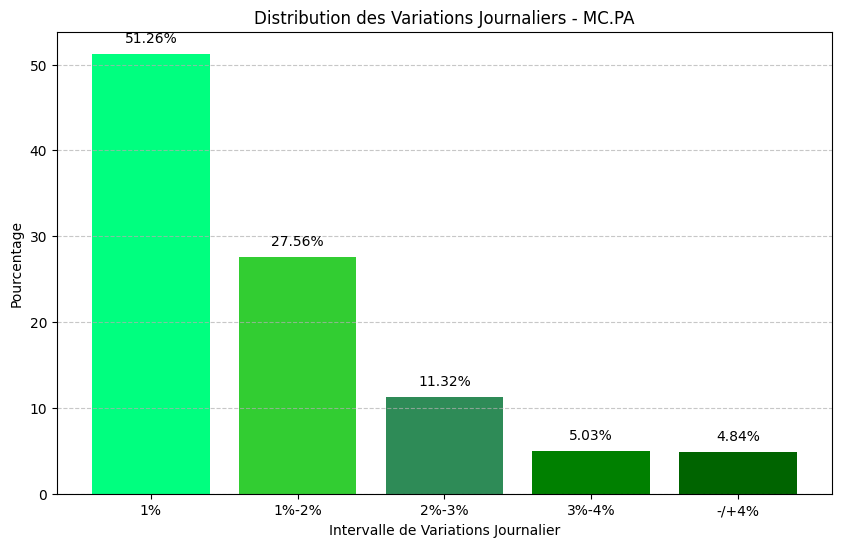

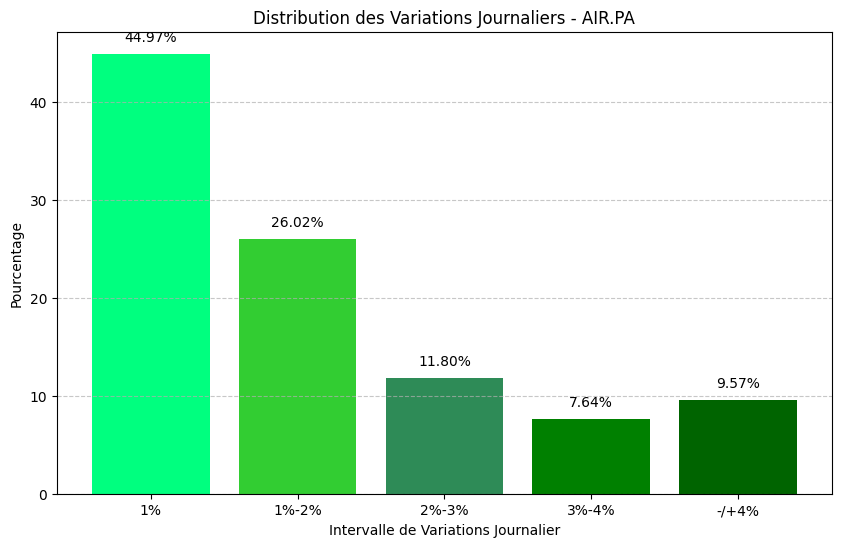

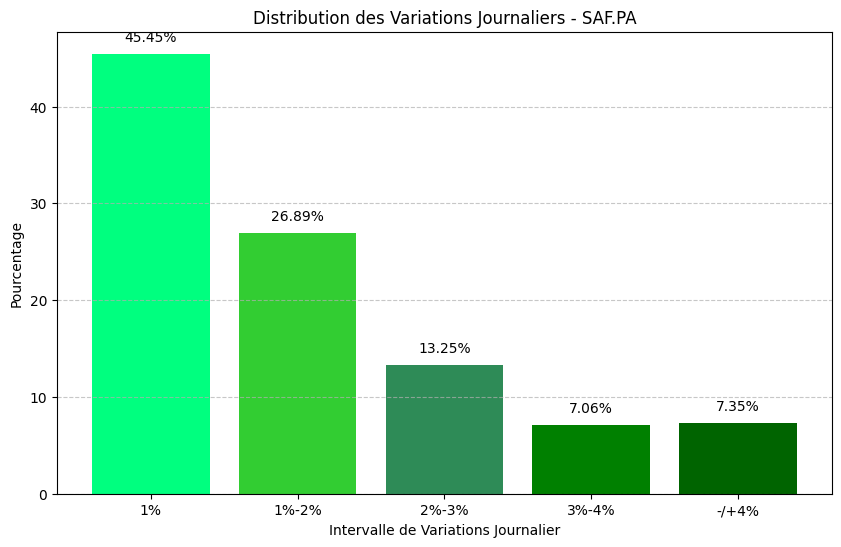

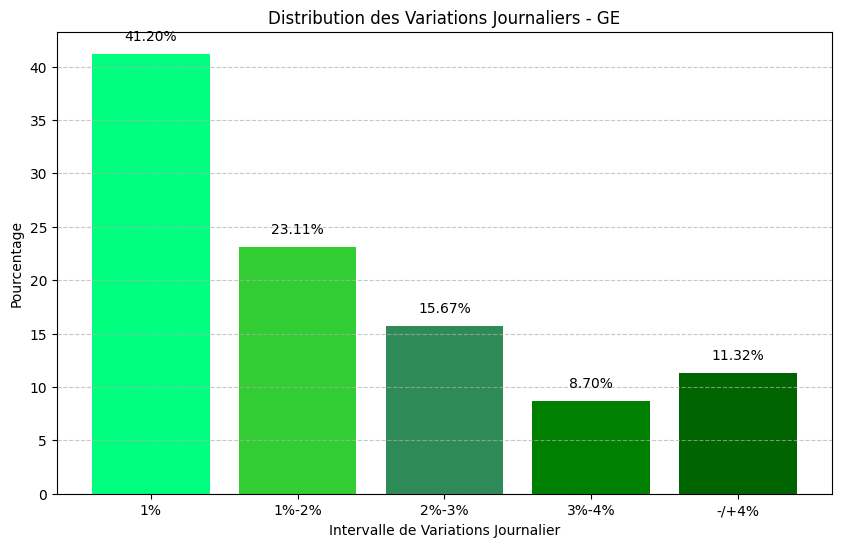

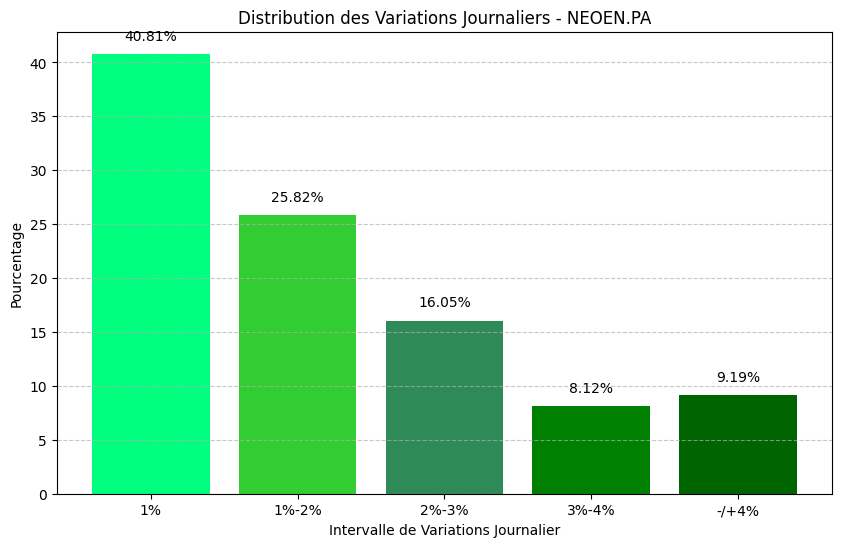

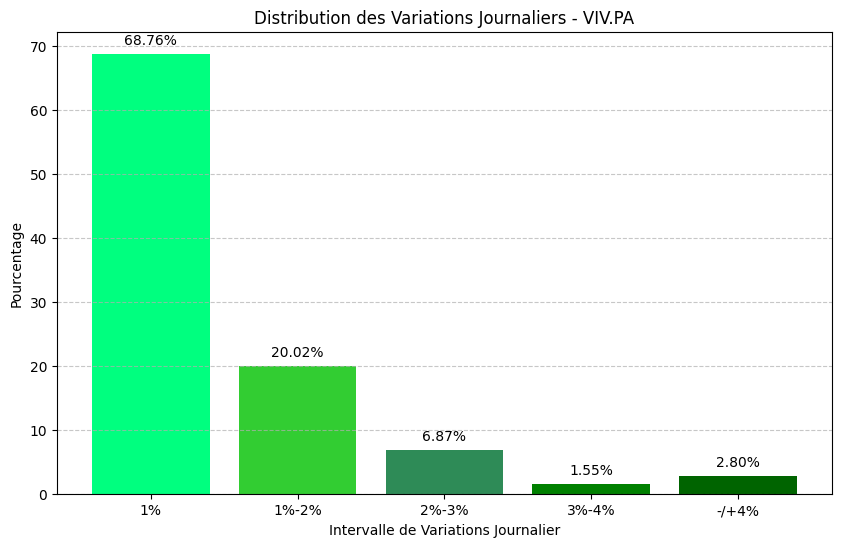

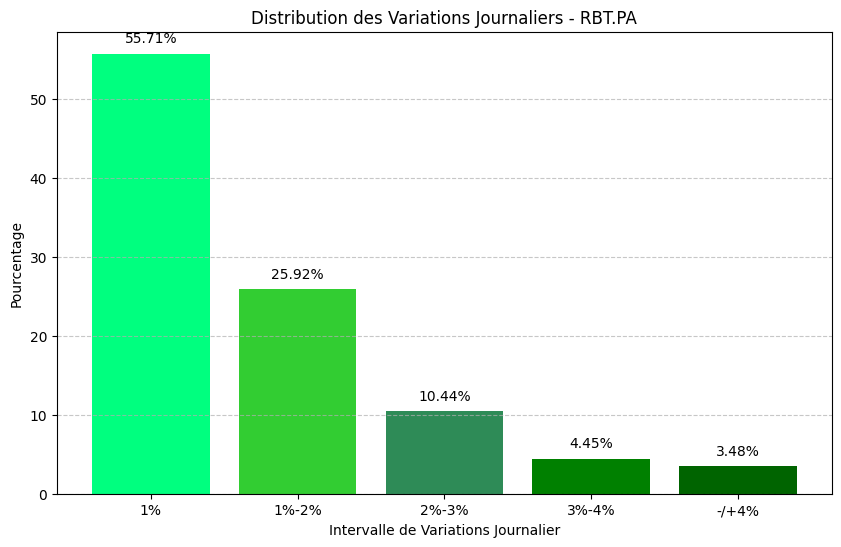

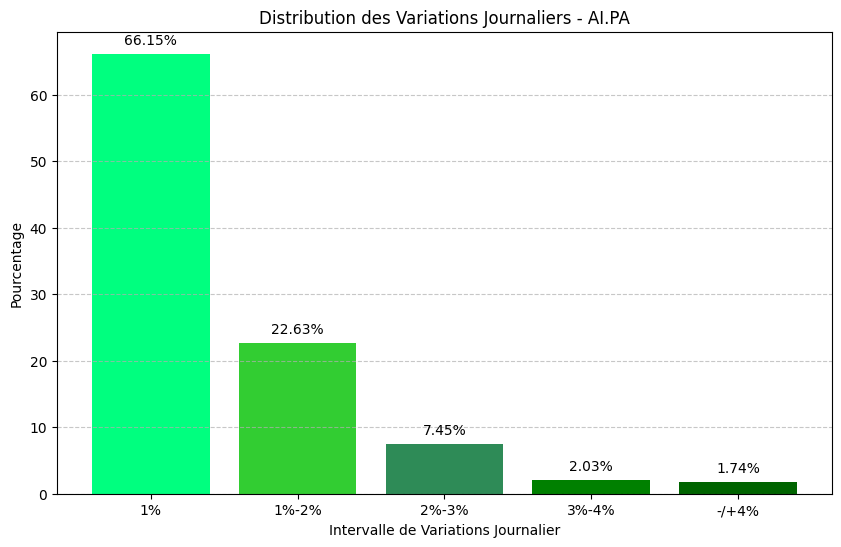

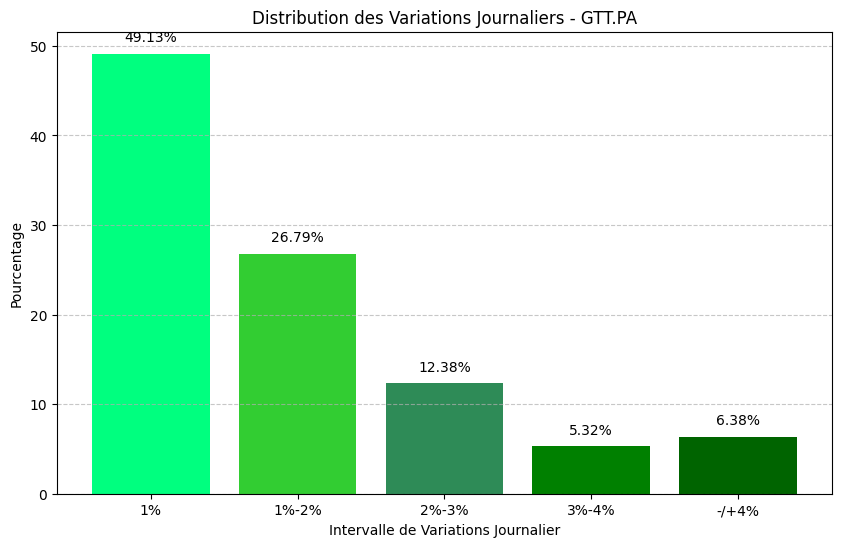

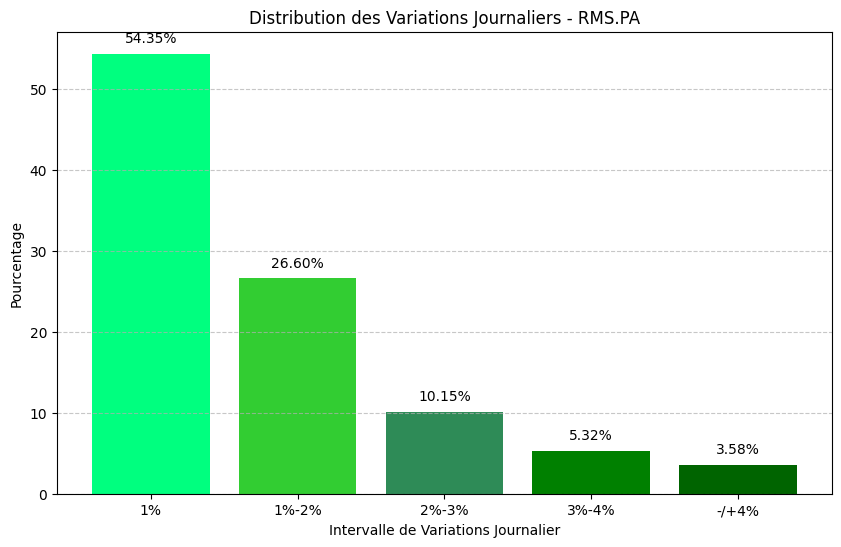

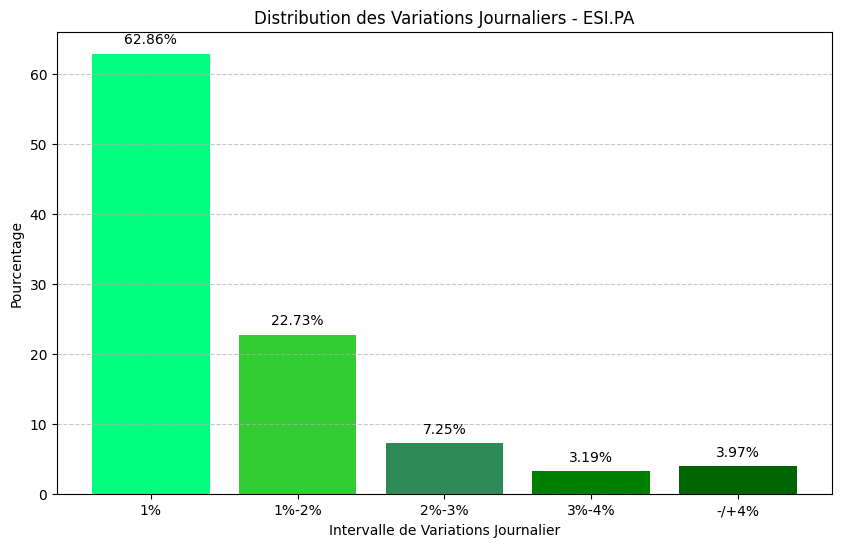

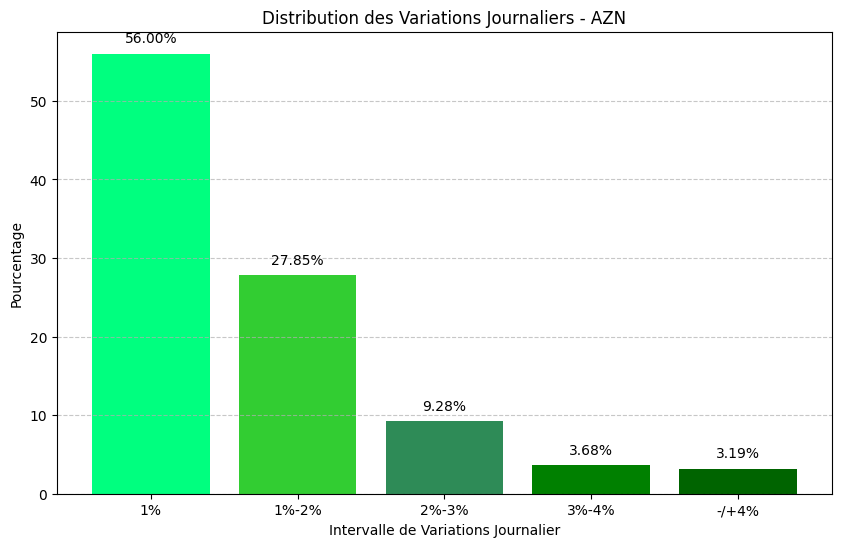

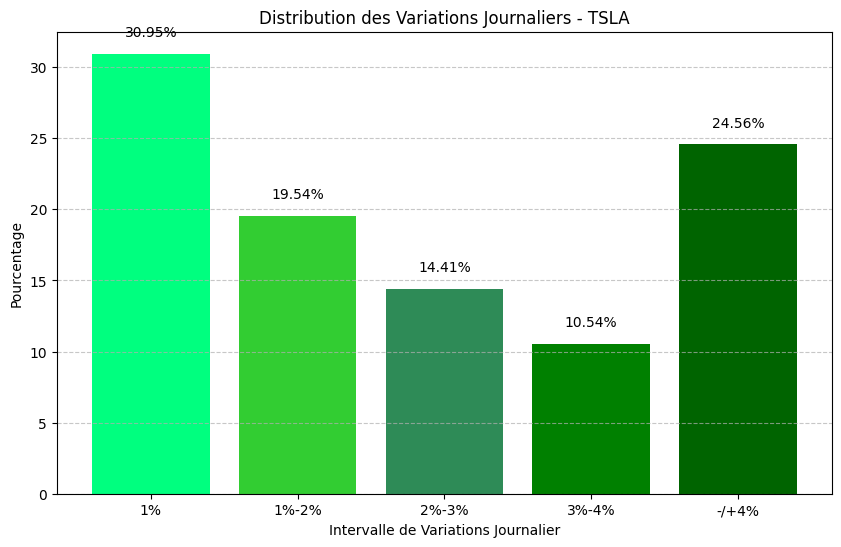

In [ ]:
for ticker in tickers:
    # Calculer les pourcentages pour les intervalles exclusifs
    percentages = [
        len(daily_returns[(daily_returns[ticker] > -0.01) & (daily_returns[ticker] <= 0.01)]) / len(daily_returns[ticker].dropna()) * 100,
        (len(daily_returns[(daily_returns[ticker] > -0.02) & (daily_returns[ticker] <= 0.02)]) - len(daily_returns[(daily_returns[ticker] > -0.01) & (daily_returns[ticker] <= 0.01)])) / len(daily_returns[ticker].dropna()) * 100,
        (len(daily_returns[(daily_returns[ticker] > -0.03) & (daily_returns[ticker] <= 0.03)]) - len(daily_returns[(daily_returns[ticker] > -0.02) & (daily_returns[ticker] <= 0.02)])) / len(daily_returns[ticker].dropna()) * 100,
        (len(daily_returns[(daily_returns[ticker] > -0.04) & (daily_returns[ticker] <= 0.04)]) - len(daily_returns[(daily_returns[ticker] > -0.03) & (daily_returns[ticker] <= 0.03)])) / len(daily_returns[ticker].dropna()) * 100,
        len(daily_returns[(daily_returns[ticker] < -0.04) | (daily_returns[ticker] > 0.04)]) / len(daily_returns[ticker].dropna()) * 100
    ]

    # Labels des intervalles
    intervals = ['1%', '1%-2%', '2%-3%', '3%-4%', '-/+4%']

    # Créer un graphique à barres
    plt.figure(figsize=(10, 6))
    plt.bar(intervals, percentages, color=['springgreen', 'limegreen', 'seagreen', 'green', 'darkgreen'])

    # Ajouter des étiquettes et un titre
    plt.xlabel('Intervalle de Variations Journalier')
    plt.ylabel('Pourcentage')
    plt.title(f'Distribution des Variations Journaliers - {ticker}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Ajouter des étiquettes de pourcentage au-dessus des barres
    for i, percentage in enumerate(percentages):
        plt.text(i, percentage + 1, f'{percentage:.2f}%', ha='center', va='bottom')

    # Afficher le graphique
    plt.show()


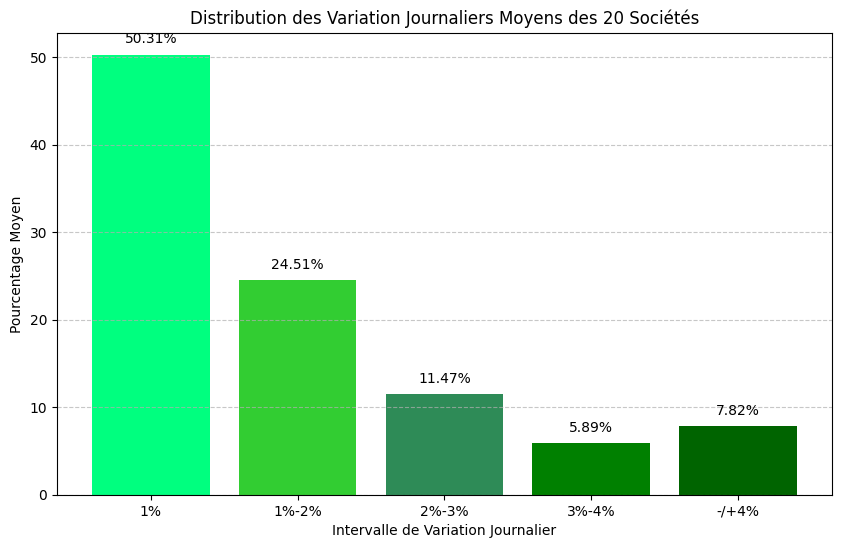

In [ ]:
# Initialisation de la liste pour stocker les pourcentages de tous les tickers
all_percentages = []

for ticker in tickers:
    # Calculer les pourcentages pour les intervalles exclusifs
    percentages = [
        len(daily_returns[(daily_returns[ticker] > -0.01) & (daily_returns[ticker] <= 0.01)]) / len(daily_returns[ticker].dropna()) * 100,
        (len(daily_returns[(daily_returns[ticker] > -0.02) & (daily_returns[ticker] <= 0.02)]) - len(daily_returns[(daily_returns[ticker] > -0.01) & (daily_returns[ticker] <= 0.01)])) / len(daily_returns[ticker].dropna()) * 100,
        (len(daily_returns[(daily_returns[ticker] > -0.03) & (daily_returns[ticker] <= 0.03)]) - len(daily_returns[(daily_returns[ticker] > -0.02) & (daily_returns[ticker] <= 0.02)])) / len(daily_returns[ticker].dropna()) * 100,
        (len(daily_returns[(daily_returns[ticker] > -0.04) & (daily_returns[ticker] <= 0.04)]) - len(daily_returns[(daily_returns[ticker] > -0.03) & (daily_returns[ticker] <= 0.03)])) / len(daily_returns[ticker].dropna()) * 100,
        len(daily_returns[(daily_returns[ticker] < -0.04) | (daily_returns[ticker] > 0.04)]) / len(daily_returns[ticker].dropna()) * 100
    ]

    # Ajouter les pourcentages de ce ticker à la liste globale
    all_percentages.append(percentages)

# Calculer les pourcentages moyens pour chaque intervalle sur tous les tickers
mean_percentages = [sum(x)/len(x) for x in zip(*all_percentages)]

# Labels des intervalles
intervals = ['1%', '1%-2%', '2%-3%', '3%-4%', '-/+4%']

# Créer un graphique à barres
plt.figure(figsize=(10, 6))
plt.bar(intervals, mean_percentages, color=['springgreen', 'limegreen', 'seagreen', 'green', 'darkgreen'])

# Ajouter des étiquettes et un titre
plt.xlabel('Intervalle de Variation Journalier')
plt.ylabel('Pourcentage Moyen')
plt.title('Distribution des Variation Journaliers Moyens des 20 Sociétés')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajouter des étiquettes de pourcentage au-dessus des barres
for i, percentage in enumerate(mean_percentages):
    plt.text(i, percentage + 1, f'{percentage:.2f}%', ha='center', va='bottom')

# Afficher le graphique
plt.show()

Le rendement de VLTSA.PA est de 114.53% sur la période donnée.
Le rendement de OR.PA est de 79.69% sur la période donnée.
Le rendement de SQI.PA est de 172.61% sur la période donnée.
Le rendement de ALEMG.PA est de -27.12% sur la période donnée.
Le rendement de FDE.PA est de 248.67% sur la période donnée.
Le rendement de SU.PA est de 145.35% sur la période donnée.
Le rendement de FII.PA est de -8.85% sur la période donnée.
Le rendement de MC.PA est de 187.72% sur la période donnée.
Le rendement de AIR.PA est de 40.12% sur la période donnée.
Le rendement de SAF.PA est de 15.71% sur la période donnée.
Le rendement de GE est de 37.57% sur la période donnée.
Le rendement de NEOEN.PA est de 98.00% sur la période donnée.
Le rendement de VIV.PA est de -54.06% sur la période donnée.
Le rendement de RBT.PA est de 71.20% sur la période donnée.
Le rendement de AI.PA est de 64.07% sur la période donnée.
Le rendement de GTT.PA est de 78.61% sur la période donnée.
Le rendement de RMS.PA est de 210.4

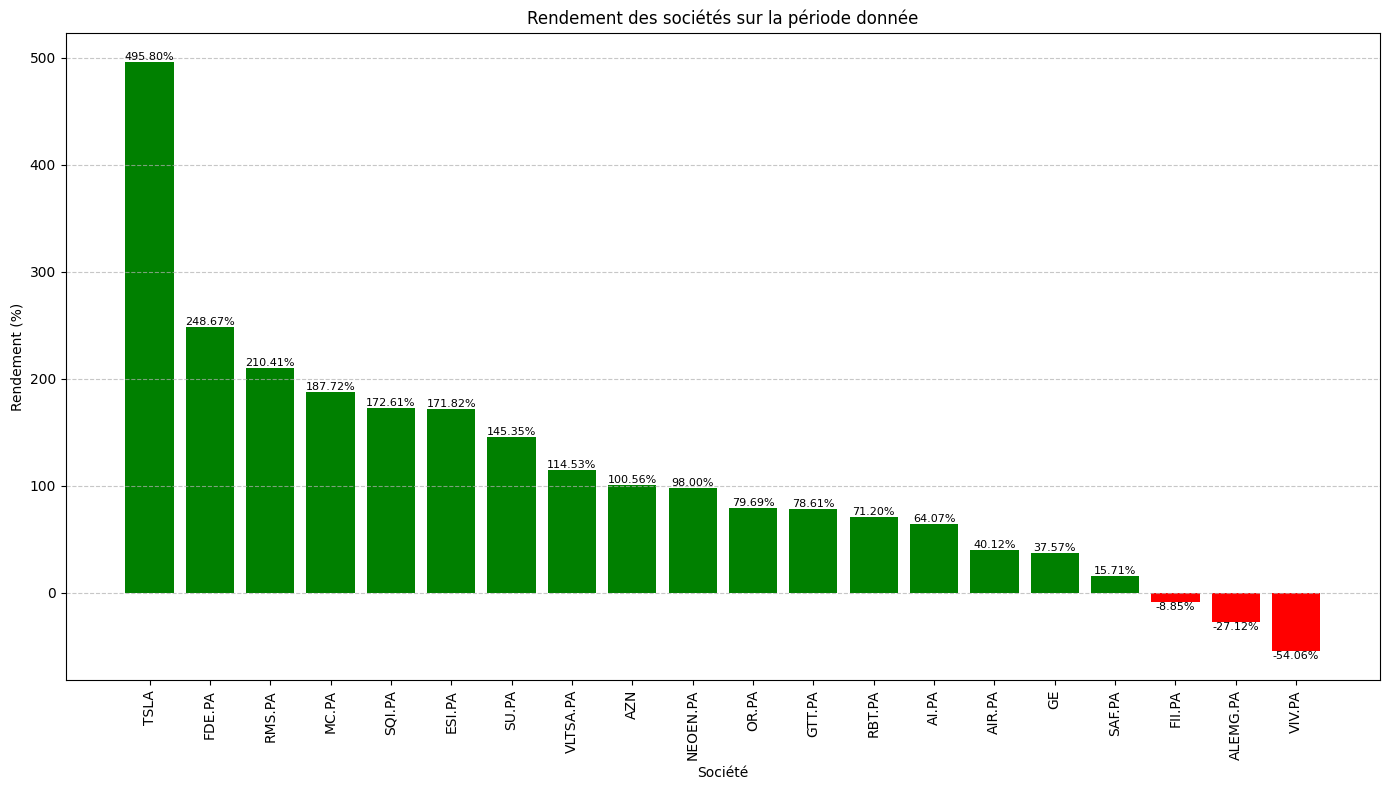

In [ ]:
# Fonction pour calculer le rendement avec les données disponibles les plus proches
def calculate_nearest_return(data, ticker):
    # Si la première valeur est NaN, prend la première valeur non-NaN
    first_valid_price = data[ticker].first_valid_index()
    # Si la dernière valeur est NaN, prend la dernière valeur non-NaN
    last_valid_price = data[ticker].last_valid_index()
    # Calcul du rendement
    return_value = (data[ticker].loc[last_valid_price] - data[ticker].loc[first_valid_price]) / data[ticker].loc[first_valid_price] * 100
    return return_value

# Calcul des rendements pour chaque ticker
returns = {ticker: calculate_nearest_return(data, ticker) for ticker in tickers}

# Affichage des rendements
for ticker, return_value in returns.items():
    print(f"Le rendement de {ticker} est de {return_value:.2f}% sur la période donnée.")

# Tri des rendements du plus grand au plus petit
sorted_returns = dict(sorted(returns.items(), key=lambda item: item[1], reverse=True))

# Création du DataFrame à partir du dictionnaire de rendements
df = pd.DataFrame(list(sorted_returns.items()), columns=['Company', 'Return'])

# Couleurs des barres en fonction du rendement
bar_colors = ['green' if x > 0 else 'red' for x in df['Return']]

# Création du graphique à barres
plt.figure(figsize=(14, 8))
bars = plt.bar(df['Company'], df['Return'], color=bar_colors)

# Ajout des étiquettes de pourcentage
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}%',
             va='bottom' if yval > 0 else 'top', ha='center', fontsize=8)

# Configuration des titres et étiquettes
plt.title('Rendement des sociétés sur la période donnée')
plt.xlabel('Société')
plt.ylabel('Rendement (%)')
plt.xticks(rotation=90)  # Rotation des étiquettes pour une meilleure lisibilité
plt.tight_layout()  # Ajustement automatique pour éviter le chevauchement
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Affichage du graphique
plt.show()

In [ ]:
def calculate_nearest_return(data, ticker):
    # Si la première valeur est NaN, prend la première valeur non-NaN
    first_valid_price = data[ticker].first_valid_index()
    # Si la dernière valeur est NaN, prend la dernière valeur non-NaN
    last_valid_price = data[ticker].last_valid_index()
    # Calcul du rendement
    return_value = (data[ticker].loc[last_valid_price] - data[ticker].loc[first_valid_price]) / data[ticker].loc[first_valid_price] * 100
    return return_value

def calculate_annualized_return(total_return, start_date, end_date):
    # Calculate the number of years between the start and end date
    period_years = 5
    # Calculate the annualized return
    annualized_return = ((1 + total_return / 100) ** (1 / period_years) - 1) * 100
    return annualized_return

# Let's define the start and end dates for the calculation
start_date = data.index.min()
end_date = data.index.max()

# Calculate the total returns for each ticker
returns = {ticker: calculate_nearest_return(data, ticker) for ticker in tickers}

# Calculate the annualized returns for each ticker
annualized_returns = {ticker: calculate_annualized_return(return_value, start_date, end_date) for ticker, return_value in returns.items()}

# Create a DataFrame from the annualized returns
annualized_returns_df = pd.DataFrame(list(annualized_returns.items()), columns=['Company', 'Annualized Return'])
annualized_returns_df.sort_values(by='Annualized Return', ascending=False, inplace=True)

# Display the annualized returns
annualized_returns_df

Company  Annualized Return
19      TSLA          42.896086
4     FDE.PA          28.375917
16    RMS.PA          25.425898
7      MC.PA          23.536387
2     SQI.PA          22.210869
17    ESI.PA          22.139830
5      SU.PA          19.661983
0   VLTSA.PA          16.492877
18       AZN          14.933562
11  NEOEN.PA          14.639322
1      OR.PA          12.435756
15    GTT.PA          12.300747
13    RBT.PA          11.352574
14     AI.PA          10.408773
8     AIR.PA           6.979189
10        GE           6.586579
9     SAF.PA           2.961647
6     FII.PA          -1.837226
3   ALEMG.PA          -6.131424
12    VIV.PA         -14.407906

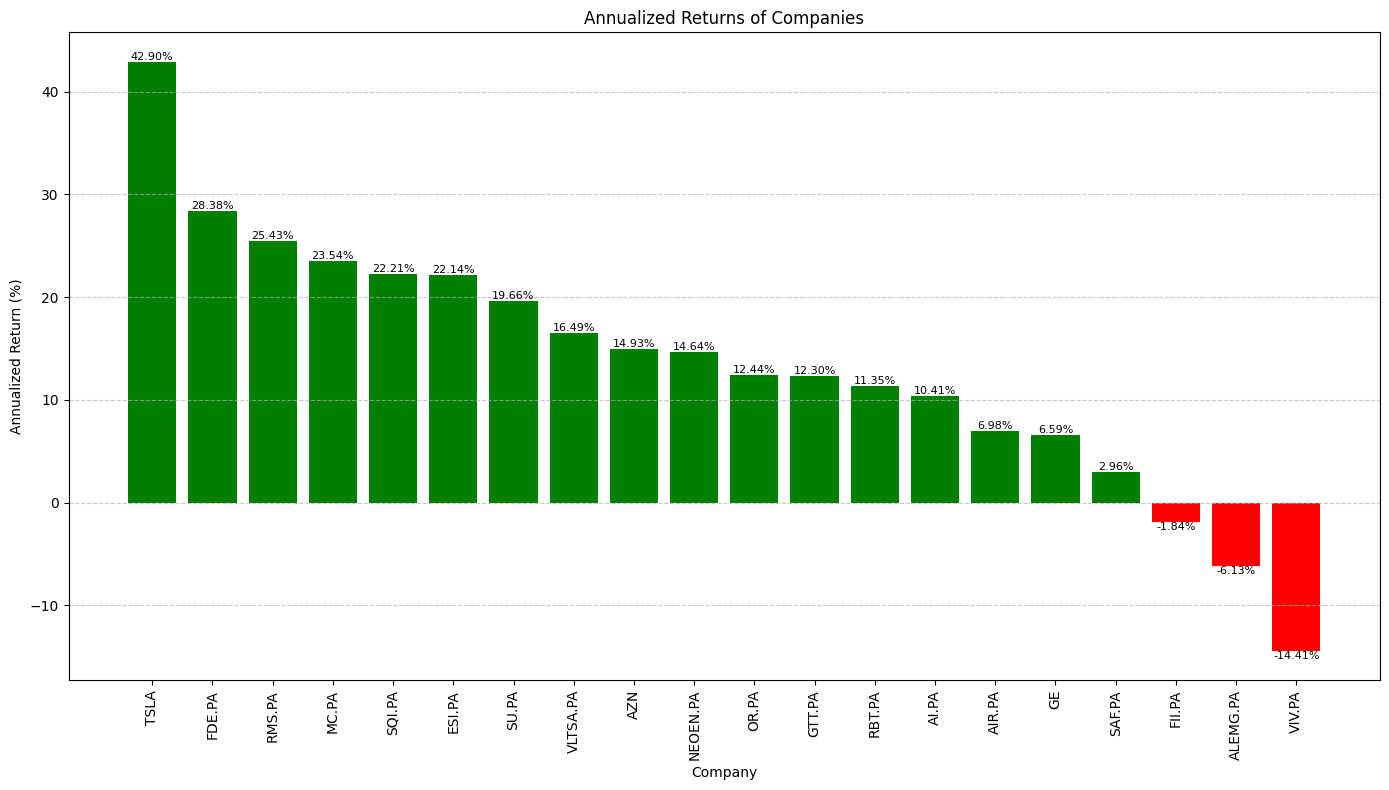

In [ ]:
# Create bar colors based on positive or negative returns
bar_colors = ['green' if x >= 0 else 'red' for x in annualized_returns_df['Annualized Return']]

# Create the bar chart
plt.figure(figsize=(14, 8))
bars = plt.bar(annualized_returns_df['Company'], annualized_returns_df['Annualized Return'], color=bar_colors)

# Add percentage annotations above green bars and below red bars
for bar in bars:
    yval = bar.get_height()
    if yval >= 0:
        plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}%', ha='center', va='bottom', fontsize=8)
    else:
        plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}%', ha='center', va='top', fontsize=8)

# Set the title and labels
plt.title('Annualized Returns of Companies')
plt.xlabel('Company')
plt.ylabel('Annualized Return (%)')
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()  # Adjust layout to fit all labels
plt.show()

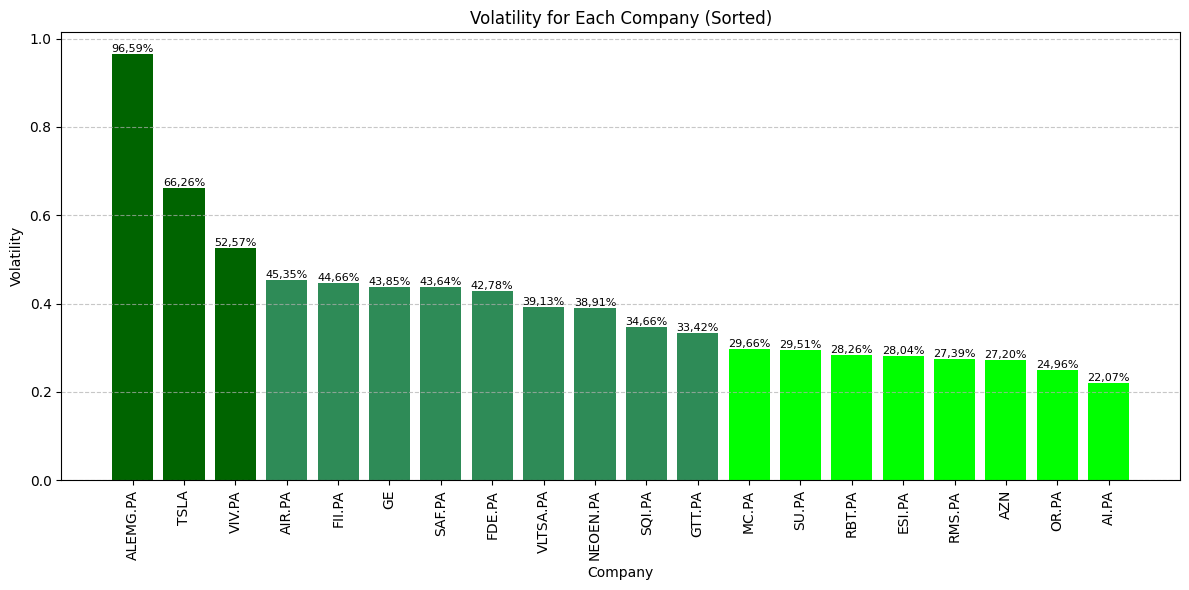

ALEMG.PA    0.965858
TSLA        0.662628
VIV.PA      0.525676
AIR.PA      0.453510
FII.PA      0.446585
GE          0.438547
SAF.PA      0.436419
FDE.PA      0.427766
VLTSA.PA    0.391331
NEOEN.PA    0.389145
SQI.PA      0.346585
GTT.PA      0.334212
MC.PA       0.296588
SU.PA       0.295098
RBT.PA      0.282617
ESI.PA      0.280446
RMS.PA      0.273900
AZN         0.272041
OR.PA       0.249617
AI.PA       0.220735
dtype: float64

In [ ]:
# Calculate the annualized volatility for each ticker
volatility = daily_returns.std() * np.sqrt(252)

# Sort volatility values in descending order
sorted_volatility = volatility.sort_values(ascending=False)

# Define colors based on volatility thresholds
colors = np.where(sorted_volatility > 0.5, 'darkgreen', np.where(sorted_volatility > 0.3, 'seagreen', 'lime'))

# Plot the volatility bar chart without using the 'plot' method to avoid color conflict
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_volatility.index, sorted_volatility, color=colors)
plt.title('Volatility for Each Company (Sorted)')
plt.xlabel('Company')
plt.ylabel('Volatility')
plt.xticks(rotation=90)  # Rotate the tickers for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels above each bar (formatted as percentages with two decimal places and a comma as the decimal separator)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval*100:.2f}'.replace('.', ',') + '%',
             va='bottom', ha='center', fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()

# Sort volatility values in descending order
sorted_volatility = volatility.sort_values(ascending=False)

# Display sorted volatility values
sorted_volatility

In [ ]:
# Télécharger les données
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculer la moyenne et l'écart-type des prix
mean_price = data.mean()
std_price = data.std()

# Filtrer les valeurs qui sont à moins de 3 écarts-types de la moyenne
filtered_data = data[(np.abs(data - mean_price) <= (3 * std_price)).all(axis=1)]

# Somme des prix pour chaque date après le filtrage
sum_prices_filtered = filtered_data.sum(axis=1)

# Afficher le nouveau DataFrame
print(sum_prices_filtered)

[*********************100%%**********************]  20 of 20 completed


Date
2019-01-02    1955.186348
2019-01-03    1927.071012
2019-01-04    1980.439690
2019-01-07    1977.912392
2019-01-08    1989.822214
                 ...     
2022-12-22    4371.445669
2022-12-23    4332.140898
2022-12-27    4372.472311
2022-12-28    4366.025353
2022-12-29    4411.754790
Length: 982, dtype: float64


In [ ]:
# Sélectionnez les valeurs à la première et à la dernière date
prix_initial = sum_prices_filtered.iloc[0]  # Premier élément
prix_final = sum_prices_filtered.iloc[-1]  # Dernier élément

# Calculez le rendement total en pourcentage
rendement_total = ((prix_final - prix_initial) / prix_initial) * 100

# Affichez le rendement total
print("Rendement total en pourcentage:", rendement_total, "%")

Rendement total en pourcentage: 125.64369861246247 %


In [ ]:
# Calculez le nombre total d'années
nb_jours = (sum_prices_filtered.index[-1] - sum_prices_filtered.index[0]).days
nb_annees = nb_jours / 365  # Inclure les années bissextiles

# Calculez le rendement total
rendement_total = (prix_final - prix_initial) / prix_initial

# Calculez le rendement annualisé
rendement_annualise = (1 + rendement_total) ** (1 / nb_annees) - 1

# Affichez le rendement annualisé
print("Rendement annualisé en pourcentage:", rendement_annualise * 100, "%")

Rendement annualisé en pourcentage: 22.613341827237843 %


In [ ]:
# Annual Volatility Portfolio with 5% weight each company
# Calculez la matrice de covariance des rendements quotidiens
cov_matrix = daily_returns.cov()

# Définissez les pondérations du portefeuille (5% pour chaque action)
weights = np.array([0.05] * 20)

# Calculez la volatilité du portefeuille
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252) *100

print(f"La volatilité annuelle du portefeuille est : {portfolio_volatility}%")

La volatilité annuelle du portefeuille est : 19.369651552584777%


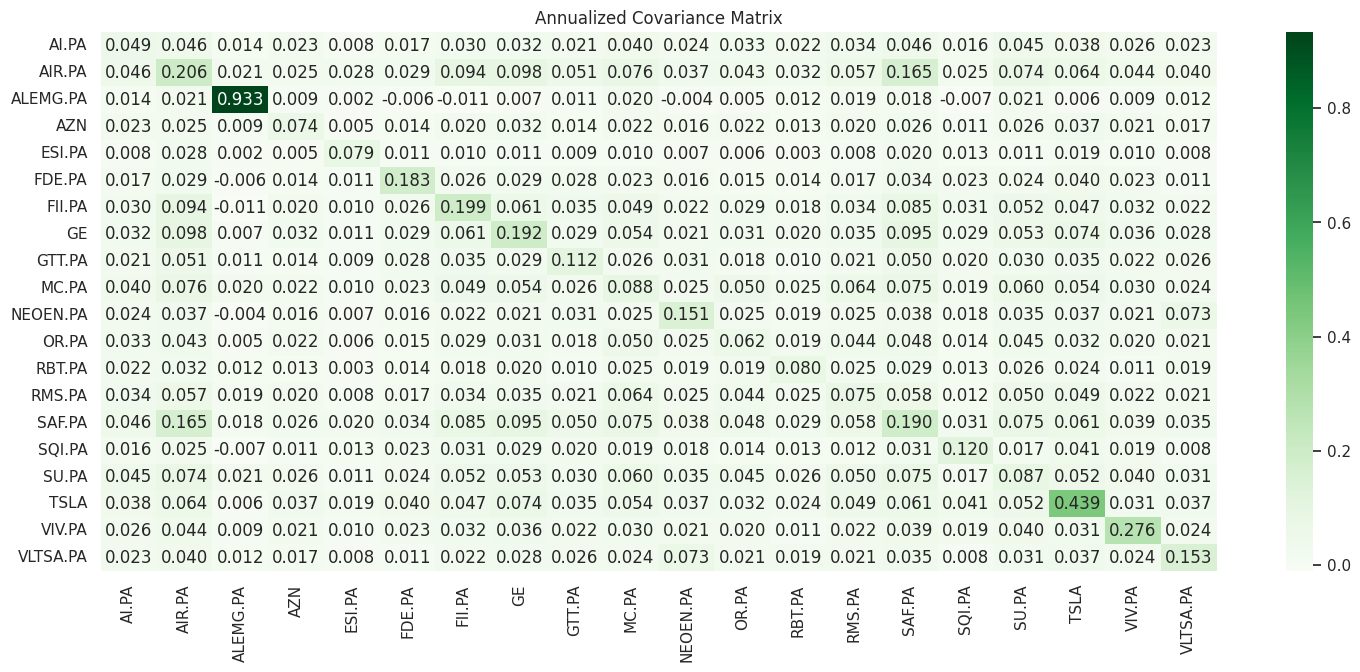

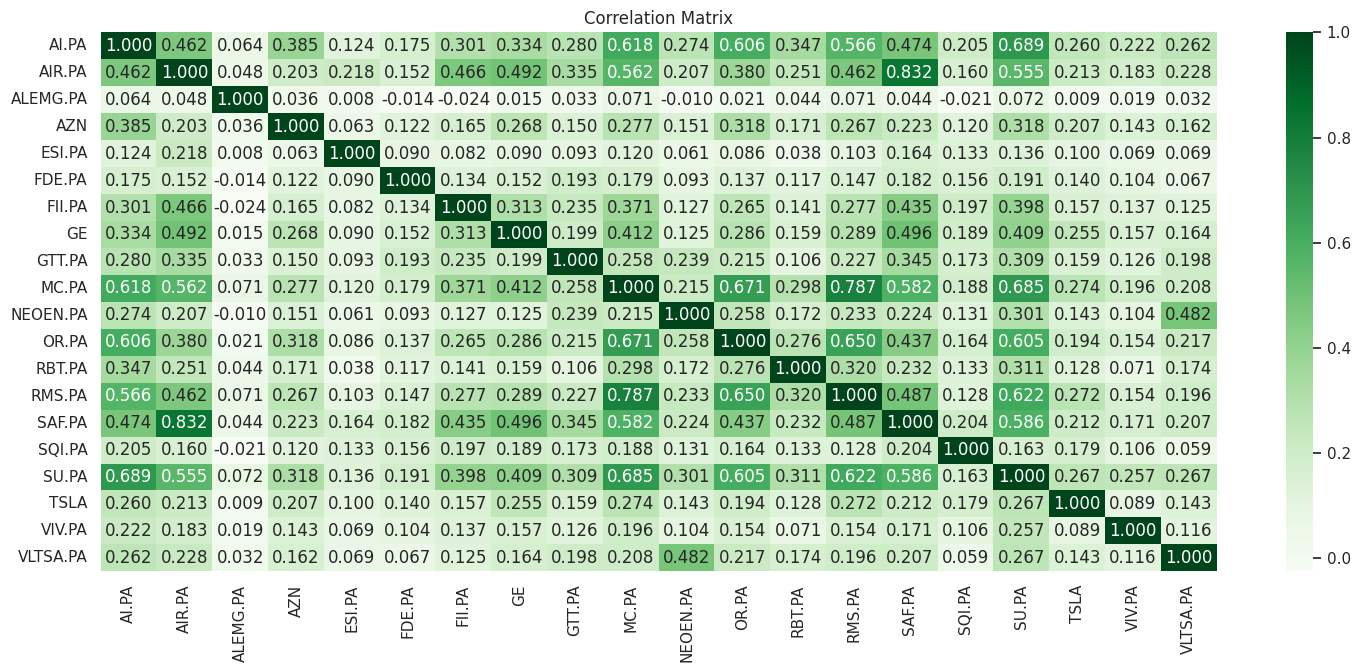

In [ ]:
# Calculate the annualized covariance matrix
annual_covariance = daily_returns.cov() * 252

# Calculate the correlation matrix
correlation = daily_returns.corr()

# Set the seaborn style
sns.set(style="whitegrid")

# Plotting the annualized covariance matrix with a green color map
plt.figure(figsize=(18, 7))
plt.title('Annualized Covariance Matrix')
cov_plot = sns.heatmap(annual_covariance, annot=True, fmt=".3f", cmap='Greens')
plt.show()

# Plotting the correlation matrix with a green color map
plt.figure(figsize=(18, 7))
plt.title('Correlation Matrix')
corr_plot = sns.heatmap(correlation, annot=True, fmt=".3f", cmap='Greens')
plt.show()

In [ ]:
num_stocks = len(tickers)

# Generate 20 random values that sum to 1
weights = np.random.random(num_stocks)
weights /= np.sum(weights)
weights = np.round(weights, decimals= 4)
print('Weights :', weights)
print('Total Weight :', np.sum(weights))

Weights : [0.072  0.0301 0.015  0.0905 0.0114 0.0786 0.0918 0.0577 0.0639 0.0269
 0.0734 0.0751 0.0791 0.0019 0.0837 0.017  0.028  0.0662 0.0187 0.0189]
Total Weight : 0.9999


In [ ]:
daily_returns = np.log(data / data.shift(1))

# Provide return of portfolio using random weights over the whole dataset
np.sum(weights * daily_returns.mean()) * 252

0.1576120621991675

In [ ]:
np.sqrt(np.dot(weights.T, np.dot(daily_returns.cov() * 252, weights)))

0.2016479808436629

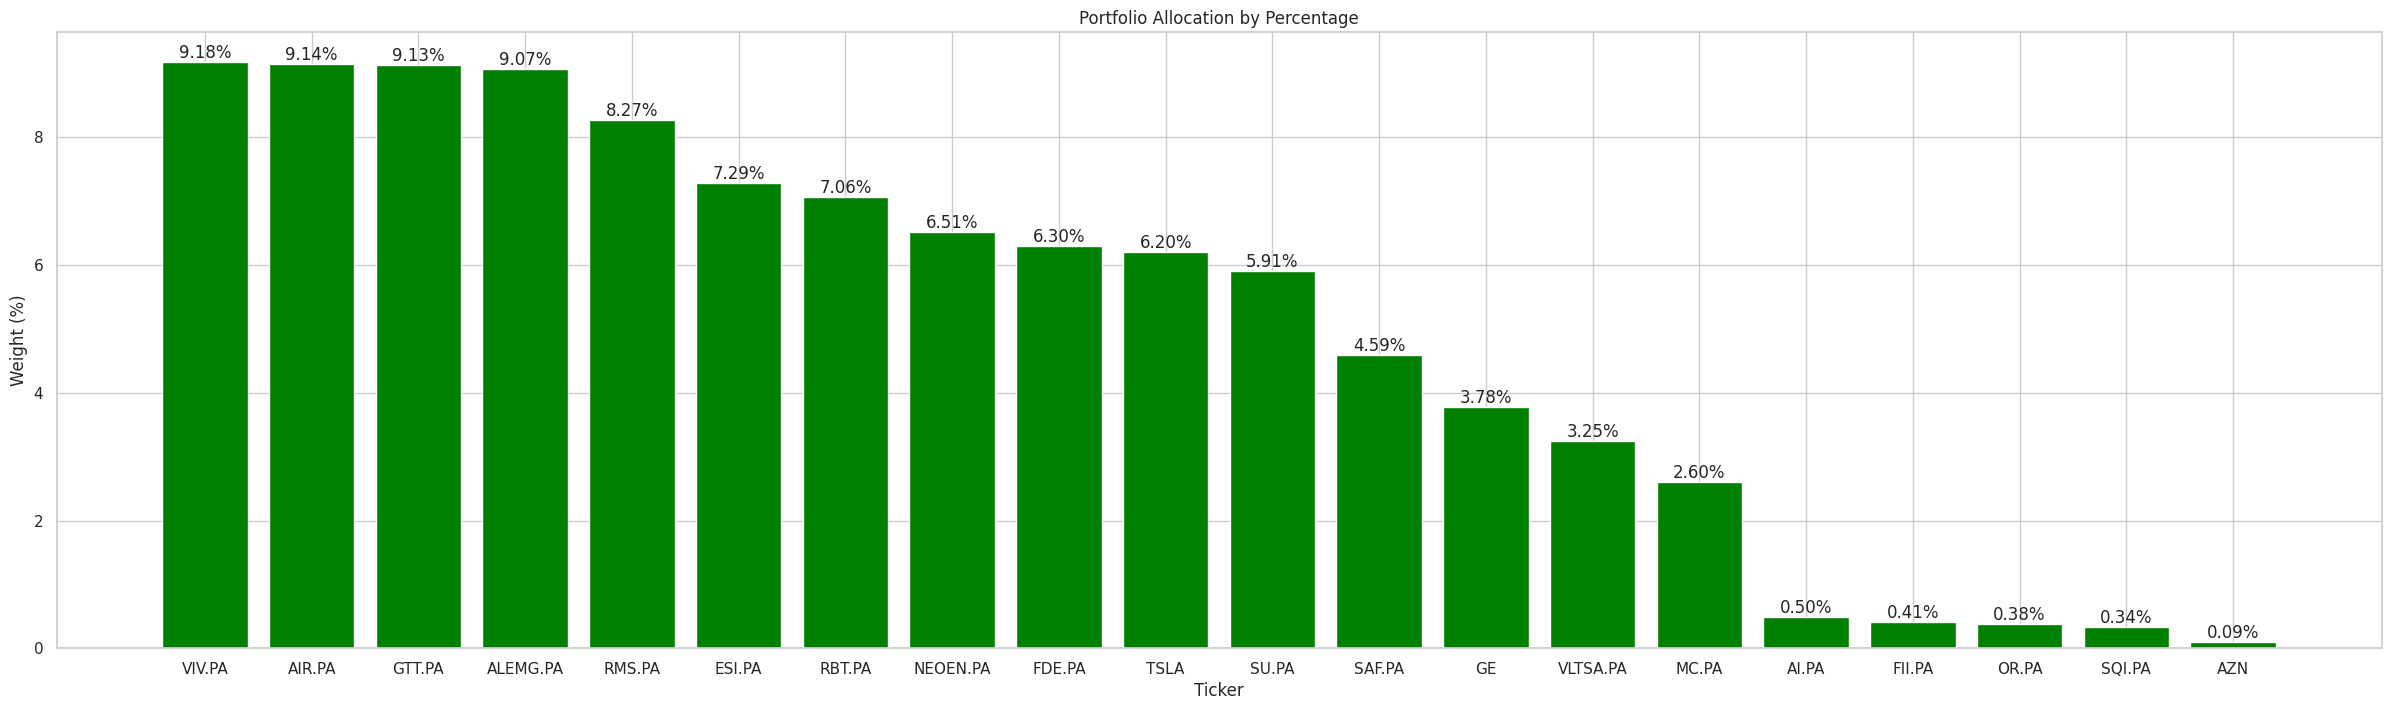

Stock : VLTSA.PA : 3.25
Stock : OR.PA : 0.38
Stock : SQI.PA : 0.34
Stock : ALEMG.PA : 9.07
Stock : FDE.PA : 6.30
Stock : SU.PA : 5.91
Stock : FII.PA : 0.41
Stock : MC.PA : 2.60
Stock : AIR.PA : 9.14
Stock : SAF.PA : 4.59
Stock : GE : 3.78
Stock : NEOEN.PA : 6.51
Stock : VIV.PA : 9.18
Stock : RBT.PA : 7.06
Stock : AI.PA : 0.50
Stock : GTT.PA : 9.13
Stock : RMS.PA : 8.27
Stock : ESI.PA : 7.29
Stock : AZN : 0.09
Stock : TSLA : 6.20


In [ ]:
p_ret = [] # Returns list
p_vol = [] # Volatility list
p_SR = [] # Sharpe Ratio list
p_wt = [] # Stock weights list

for x in range(100000):
    # Generate random weights
    p_weights = np.random.random(num_stocks)
    p_weights /= np.sum(p_weights)

    # Add return using those weights to list
    ret_1 = np.sum(p_weights * daily_returns.mean()) * 252
    p_ret.append(ret_1)

    # Add volatility or standard deviation to list
    vol_1 = np.sqrt(np.dot(p_weights.T, np.dot(daily_returns.cov() * 252, p_weights)))
    p_vol.append(vol_1)

    # Get Sharpe ratio
    risk_free_rate = 0.0325
    SR_1 = (ret_1 - risk_free_rate) / vol_1
    p_SR.append(SR_1)

    # Store the weights for each portfolio
    p_wt.append(p_weights)

# Convert to Numpy arrays
p_ret = np.array(p_ret)
p_vol = np.array(p_vol)
p_SR = np.array(p_SR)
p_wt = np.array(p_wt)

p_ret, p_vol, p_SR, p_wt

# Tri des poids dans l'ordre décroissant pour le graphique
SR_idx = np.argmax(p_SR)
optimal_weights_MC = p_wt[SR_idx]
sorted_indices = np.argsort(optimal_weights_MC)[::-1]
sorted_tickers = np.array(tickers)[sorted_indices]
sorted_weights = optimal_weights_MC[sorted_indices]

# Création du graphique avec des barres colorées et des pourcentages au-dessus
plt.figure(figsize=(30, 8))
bars = plt.bar(sorted_tickers, sorted_weights * 100, color='green')  # Multiplier par 100 pour obtenir des pourcentages

# Ajouter des étiquettes de pourcentage au-dessus de chaque barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom')

plt.title('Portfolio Allocation by Percentage')
plt.xlabel('Ticker')
plt.ylabel('Weight (%)')
plt.show()

# Return the index of the largest Sharpe Ratio
SR_idx = np.argmax(p_SR)

# Find the ideal portfolio weighting at that index
i = 0
while i < num_stocks:
    print("Stock : %s : %2.2f" % (tickers[i], (p_wt[SR_idx][i] * 100)))
    i += 1

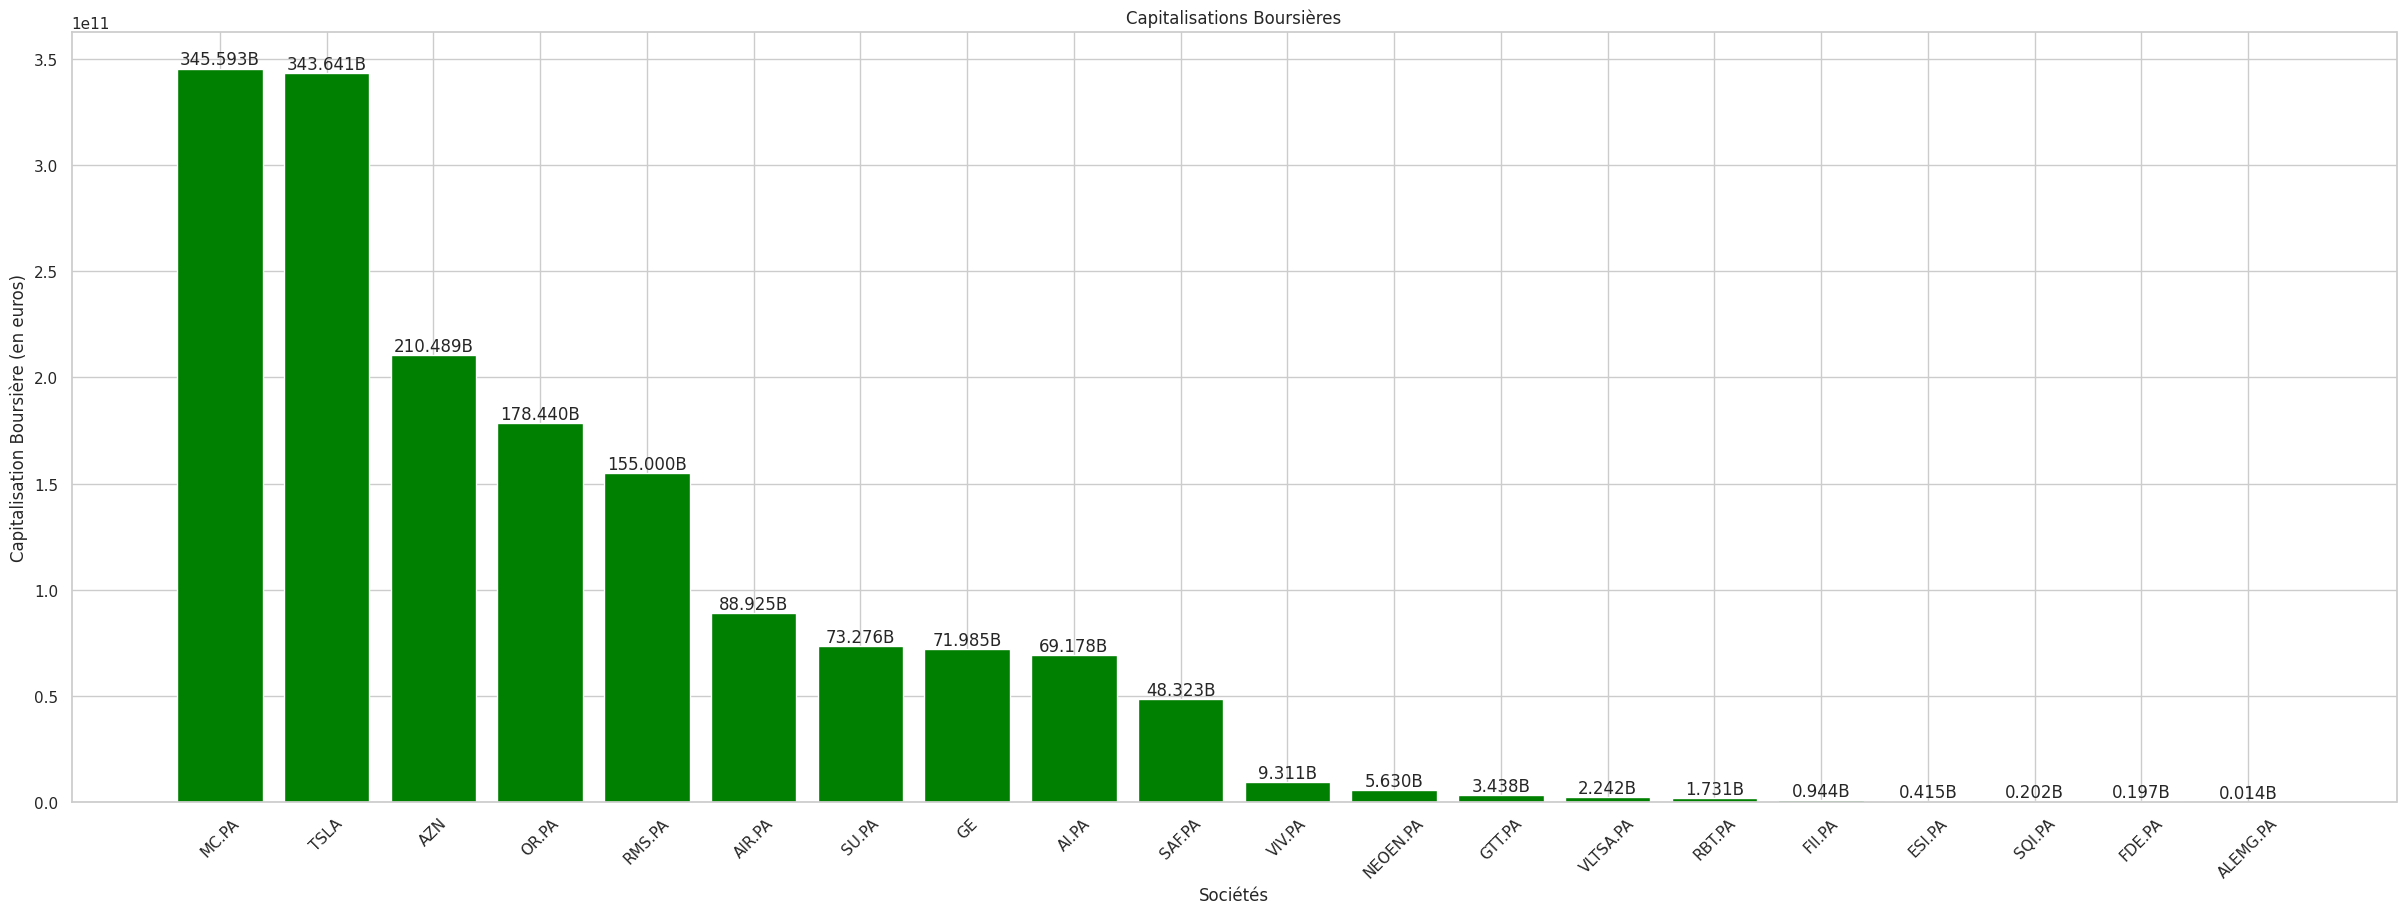

In [ ]:
# Télécharger les capitalisations boursières pour chaque société
market_caps = {}
for ticker in tickers:
    stock = yf.Ticker(ticker)
    try:
        historical_data = stock.history(start="2023-01-03", end="2023-01-04")
        market_cap = historical_data['Close'][0] * stock.info['sharesOutstanding']
        market_caps[ticker] = market_cap
    except Exception as e:
        print(f"Erreur lors de la récupération des informations pour {ticker}: {e}")

# Trier les capitalisations boursières du plus grand au plus petit
sorted_market_caps = dict(sorted(market_caps.items(), key=lambda item: item[1], reverse=True))

# Création du graphique avec des barres
plt.figure(figsize=(30, 10))
bars = plt.bar(sorted_market_caps.keys(), sorted_market_caps.values(), color='green')

# Ajouter les valeurs (en milliards) au-dessus de chaque barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval/1e9:.3f}B', ha='center', va='bottom')

plt.title('Capitalisations Boursières')
plt.xlabel('Sociétés')
plt.ylabel('Capitalisation Boursière (en euros)')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Montant total à investir
montant_total = 1000000  # 1 000 000 euros

# Nombre total de sociétés
num_companies = len(sorted_market_caps)

# Allocation de 8% à 2% en fonction de la capitalisation boursière
allocations = np.linspace(0.08, 0.02, num_companies)

# Répartir les allocations en fonction des capitalisations boursières
allocated_amounts = {company: montant_total * alloc for company, alloc in zip(sorted_market_caps, allocations)}

for entreprise, montant in allocated_amounts.items():
    pourcentage = montant / montant_total  # Convertir le montant en pourcentage du montant total
    print(f"{entreprise}: {pourcentage:.2%}")

MC.PA: 8.00%
TSLA: 7.68%
AZN: 7.37%
OR.PA: 7.05%
RMS.PA: 6.74%
AIR.PA: 6.42%
SU.PA: 6.11%
GE: 5.79%
AI.PA: 5.47%
SAF.PA: 5.16%
VIV.PA: 4.84%
NEOEN.PA: 4.53%
GTT.PA: 4.21%
VLTSA.PA: 3.89%
RBT.PA: 3.58%
FII.PA: 3.26%
ESI.PA: 2.95%
SQI.PA: 2.63%
FDE.PA: 2.32%
ALEMG.PA: 2.00%


[*********************100%%**********************]  20 of 20 completed


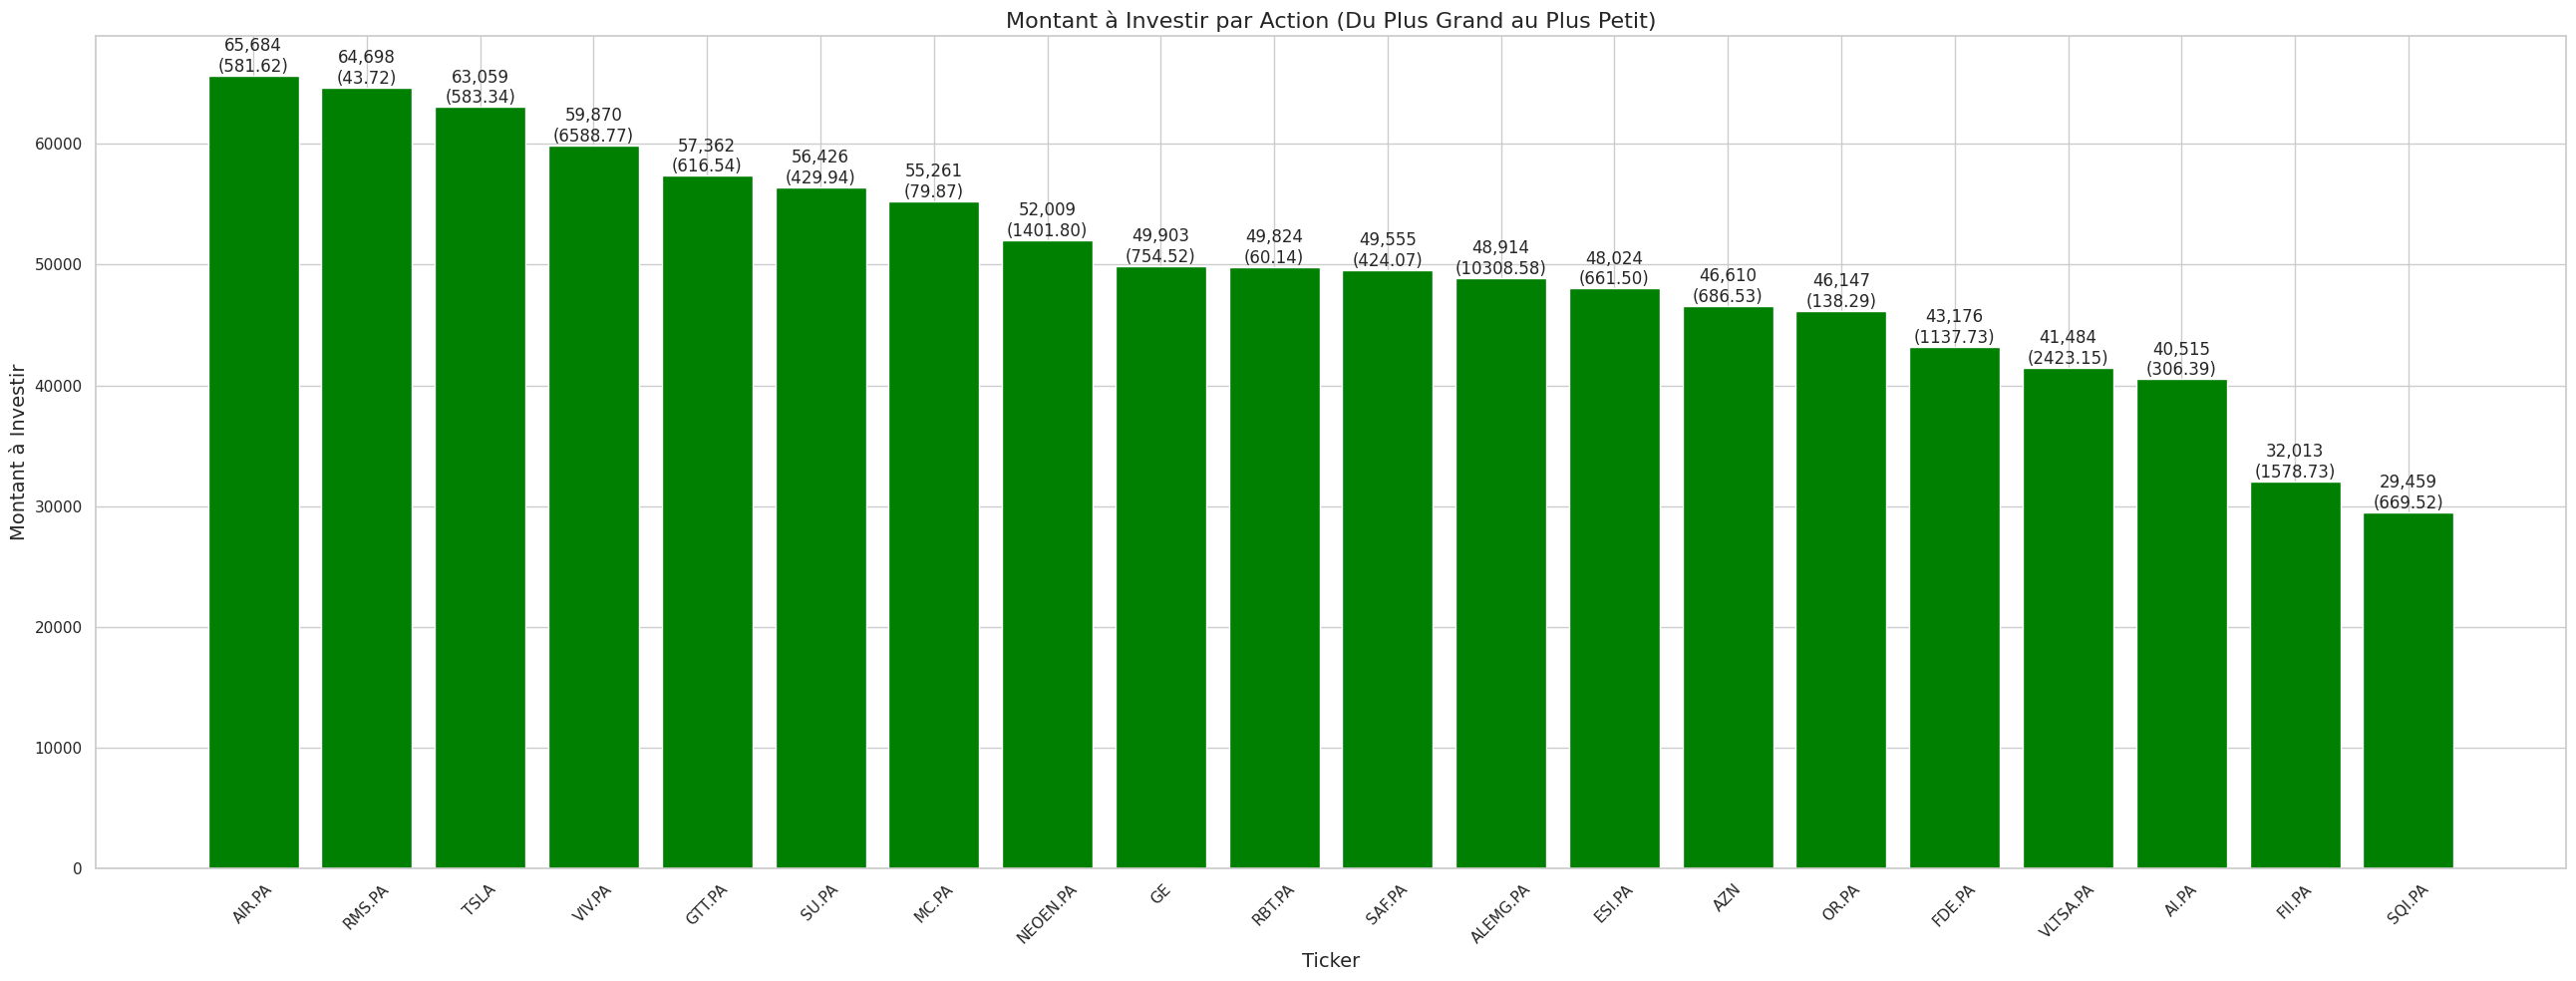

In [ ]:
# Les pourcentages d'allocation pour chaque stratégie
pourcentage_MC = 0.25
pourcentage_parts_egales = 0.375
pourcentage_degressif = 0.375

# Télécharger les données des prix des actions
data = yf.download(tickers, start="2023-01-03", end="2023-01-04")['Adj Close']

# Calculer les montants à investir basés sur la simulation de Monte Carlo
montants_MC = {ticker: montant_total * pourcentage_MC * poids for ticker, poids in zip(tickers, optimal_weights_MC)}

# Répartition à parts égales
montants_parts_egales = {ticker: montant_total * pourcentage_parts_egales / len(tickers) for ticker in tickers}

# Répartition dégressive en fonction de la capitalisation boursière
market_caps = {ticker: data[ticker][0] * yf.Ticker(ticker).info['sharesOutstanding'] for ticker in tickers}
sorted_tickers_by_cap = sorted(market_caps, key=market_caps.get, reverse=True)
degressive_allocations = np.linspace(0.08, 0.02, len(sorted_tickers_by_cap))
montants_degressifs = {ticker: montant_total * pourcentage_degressif * alloc for ticker, alloc in zip(sorted_tickers_by_cap, degressive_allocations)}

# Calcul des montants finaux à investir pour chaque société
montants_investir = {ticker: montants_MC.get(ticker, 0) + montants_parts_egales.get(ticker, 0) +
                             montants_degressifs.get(ticker, 0) for ticker in tickers}

# Calcul du nombre d'actions à acheter pour chaque société
nombre_actions = {ticker: montants_investir[ticker] / data.loc[data.index[0], ticker] for ticker in tickers}

# Création du DataFrame
investissements_df = pd.DataFrame({
    'Ticker': tickers,
    'Montant à Investir': [montants_investir[ticker] for ticker in tickers],
    'Nombre d\'Actions': [nombre_actions[ticker] for ticker in tickers]
}).sort_values(by='Montant à Investir', ascending=False)

# Création du graphique avec des barres colorées
plt.figure(figsize=(26, 10))
bars = plt.bar(investissements_df['Ticker'], investissements_df['Montant à Investir'], color='green')
plt.title('Montant à Investir par Action (Du Plus Grand au Plus Petit)', fontsize=16)
plt.xlabel('Ticker', fontsize=14)
plt.ylabel('Montant à Investir', fontsize=14)
plt.xticks(rotation=45)

# Ajout des montants sur chaque barre
for bar, montant, nbr_actions in zip(bars, investissements_df['Montant à Investir'], investissements_df['Nombre d\'Actions']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{int(montant):,}\n({nbr_actions:.2f})", va='bottom', ha='center')

plt.tight_layout()
plt.show()

Rendement moyen simulé du portefeuille sur 10 ans: 428.35%
Médiane des rendements simulés du portefeuille sur 10 ans: 355.39%


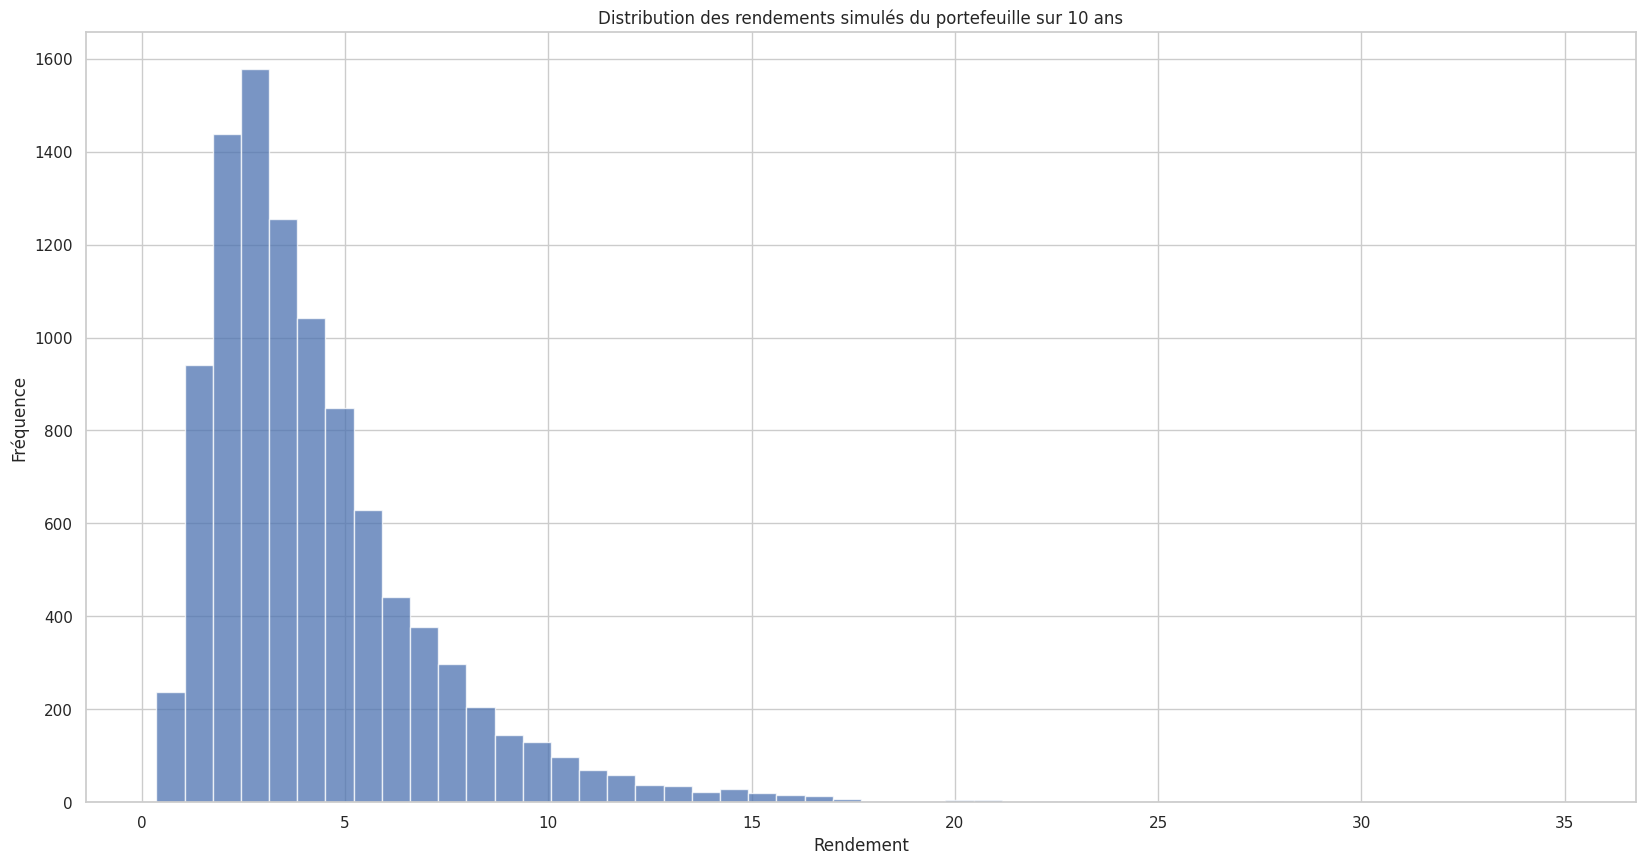

In [ ]:
# Nombre de simulations et de jours de trading pour une période de 10 ans
num_simulations = 10000
num_days = 250 * 10  # 250 jours de trading par an sur 10 ans

# Simulation de Monte Carlo pour une période de 10 ans
portfolio_returns_10_years = []
for _ in range(num_simulations):
    # Génération des rendements simulés pour chaque action sur 10 ans
    simulated_returns = np.random.multivariate_normal(mean_returns, cov_matrix, num_days)

    # Calcul du rendement total du portefeuille sur 10 ans
    total_portfolio_return = np.cumprod(np.mean(simulated_returns + 1, axis=1))[-1]
    portfolio_returns_10_years.append(total_portfolio_return)

# Analyse des résultats pour une période de 10 ans
mean_simulated_return_10_years = np.mean(portfolio_returns_10_years)
median_simulated_return_10_years = np.median(portfolio_returns_10_years)

# Affichage des résultats pour une période de 10 ans
print(f"Rendement moyen simulé du portefeuille sur 10 ans: {mean_simulated_return_10_years:.2%}")
print(f"Médiane des rendements simulés du portefeuille sur 10 ans: {median_simulated_return_10_years:.2%}")

# Tracé de l'histogramme des rendements simulés sur 10 ans
plt.figure(figsize=(20, 10))
plt.hist(portfolio_returns_10_years, bins=50, alpha=0.75)
plt.title("Distribution des rendements simulés du portefeuille sur 10 ans")
plt.xlabel("Rendement")
plt.ylabel("Fréquence")
plt.show()
